## Read data and show how many profile need to be predicted

In [343]:
# -*- coding: utf-8 -*-

import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import pylab
import numpy as np
import pickle
from collections import Counter

# load the graph
G = nx.read_gexf("mediumLinkedin.gexf")

college = {}
location = {}
employer = {}
# The dictionaries are loaded as dictionaries from the disk (see pickle in Python doc)
with open('mediumCollege_60percent_of_empty_profile.pickle', 'rb') as handle:
    college = pickle.load(handle)
with open('mediumLocation_60percent_of_empty_profile.pickle', 'rb') as handle:
    location = pickle.load(handle)
with open('mediumEmployer_60percent_of_empty_profile.pickle', 'rb') as handle:
    employer = pickle.load(handle)
# here are the empty nodes for whom your challenge is to find the profiles
empty_nodes = []
with open('mediumRemovedNodes_60percent_of_empty_profile.pickle', 'rb') as handle:
    empty_nodes = pickle.load(handle)

i = 0
for n in G:
    if len(list(G[n])) == 0:
        i += 1
print("Nb of users in our graph: %d" % len(G))
print("Nb of users with one or more attribute college: %d" % len(college))
print("Nb of users with one or more attribute location: %d" % len(location))
print("Nb of users with one or more attribute employer: %d" % len(employer))
print("Your mission, find attributes to %d users with empty profile" % len(empty_nodes))
print('isolated nodes number = ' + str(i))


Nb of users in our graph: 811
Nb of users with one or more attribute college: 230
Nb of users with one or more attribute location: 336
Nb of users with one or more attribute employer: 297
Your mission, find attributes to 475 users with empty profile
isolated nodes number = 0


## Make a function to draw a given graph with different nodes' colors

In [447]:
def drawGraph(g,color = True):
    print('drawing the Graph, be patient please ^-^')
    plt.figure(num=None, figsize=(30, 30), dpi=80)
    plt.axis('off')
    fig = plt.figure(1)
    pos = nx.spring_layout(g, iterations=100)
    if color == True:
        node_colors = [g.node[v]['color'] for v in g]
        nx.draw_networkx(g,node_color = node_colors)
    elif color == False:
        nx.draw_networkx(g)
    plt.show()

## Functions to evaluate a given prediction with using the precision

In [448]:
# Mesure the accuracy function
def evaluation_accuracy(groundtruth, pred):
    true_positive_prediction = 0
    for p_key, p_value in pred.items():
        if p_key in groundtruth:
            # if prediction is no attribute values, e.g. [] and so is the groundtruth
            # May happen
            if not p_value and not groundtruth[p_key]:
                true_positive_prediction += 1
            # counts the number of good prediction for node p_key
            # here len(p_value)=1 but we could have tried to predict more values
            true_positive_prediction += len([c for c in p_value if c in groundtruth[p_key]])
            # no else, should not happen: train and test datasets are consistent
    return true_positive_prediction*100/len(pred)

# Test function which use The evaluation_accuracy function
def testLocation(location_prediction):
    groundtruth = {}
    with open('mediumLocation.pickle', 'rb') as handle:
        groundtruth_location = pickle.load(handle)
    result = evaluation_accuracy(groundtruth_location, location_prediction)
    print('print the groudtruth rate for location_prediction')
    print("%f%% of the predictions are true" % result)
    return result
# test college
def testCollege(college_prediction):
    groundtruth = {}
    with open('mediumcollege.pickle', 'rb') as handle:
        groundtruth_college = pickle.load(handle)
    result = evaluation_accuracy(groundtruth_college, college_prediction)
    print('print the groudtruth rate for college_prediction')
    print("%f%% of the predictions are true" % result)
    return result
# test employer
def testEmployer(employer_prediction):
    groundtruth = {}
    with open('mediumEmployer.pickle', 'rb') as handle:
        groundtruth_employer = pickle.load(handle)
    result = evaluation_accuracy(groundtruth_employer, employer_prediction)
    print('print the groudtruth rate for EmployerPrediction')
    print("%f%% of the predictions are true" % result)
    return result

# First Part
## Make prediction for the missing profile

## Function of prediction 
#### We suppose that each node will have same infomation with its' neighbors 

In [449]:
from collections import ChainMap

# Prediction by the most frequent attribut
def naive_method(attr,graph, empty):
    predicted_values={}
    visited=[]
    length_empty = len(empty)
    for n in empty:
        predicted_values[n]=[]
    for i in range(3):
        attr_temp = ChainMap(attr,predicted_values)
        for n in empty:
            if predicted_values[n] == []:
                nbrs_attr_values=[] 
                for nbr in graph.neighbors(n):
                    if nbr in attr_temp:
                        for val in attr_temp[nbr]:
                            nbrs_attr_values.append(val)
                if nbrs_attr_values: # non empty list
                    cpt=Counter(nbrs_attr_values)
                    a,nb_occurrence=max(cpt.items(), key=lambda t: t[1])
                    predicted_values[n].append(a)
                
    return predicted_values

In [452]:
print(' Results for the naive method')
l = naive_method(location,G,empty_nodes)
proba = testLocation(l)
proba = testCollege(naive_method(college,G,empty_nodes))
proba = testEmployer(naive_method(employer,G,empty_nodes))

 Results for the naive method
print the groudtruth rate for location_prediction
30.736842% of the predictions are true
print the groudtruth rate for college_prediction
25.684211% of the predictions are true
print the groudtruth rate for EmployerPrediction
19.789474% of the predictions are true


## Function of prediction 
#### In this function we divide the given graph into 2 parts , nodes in a cluster or not.
#### and we suppose that nodes who are in the same cluster have same attributes and who are not will be implemented to a naive_method

In [340]:
from collections import ChainMap
# Prediction By the biggest cluster 
def prediction_by_cluster(attr,cluster_coef = 0.5,test=empty_nodes,g=G):
    #clustering analyse
    partial_clustering = nx.clustering(g)
#     print(partial_clustering)
    clusteringGroups = {}
    for pc_key in partial_clustering:
        pc_val = partial_clustering[pc_key]
        if pc_val >= cluster_coef:
            clusteringGroups[pc_key] = pc_val
    
    new_empty = []
    new_empty2 = []
    for n in test:
        for m in g[n]:
            if m in clusteringGroups and n not in new_empty:
                new_empty.append(n)
    for n in test:
        if n not in new_empty:
            new_empty2.append(n)
    
    dict1 = naive_method(attr,g,new_empty)
    at = ChainMap(dict1,attr)
    dict2 = naive_method(attr,g,new_empty2)
    dict3 = ChainMap(dict1,dict2)
    
    return dict3

In [355]:
# Result for the clustering prediction
proba = testLocation(prediction_by_cluster(location,0.5))
proba = testCollege(prediction_by_cluster(college,0.5))
proba  = testEmployer(prediction_by_cluster(employer,0.5))

print the groudtruth rate for location_prediction
22.526316% of the predictions are true
print the groudtruth rate for college_prediction
17.473684% of the predictions are true
print the groudtruth rate for EmployerPrediction
13.052632% of the predictions are true


## Function of prediction 
#### Find Louvain communities in the given graph 
#### and in each community we suppose that each node in the same community share same attribute.



In [433]:
import community
from matplotlib import colors as mcolors

def find_community(graph):
    return (community.best_partition(graph))

def prediction_by_community(attr,g=G,empty_nodes=empty_nodes):
    
    G1 = g
    

    partition = find_community(G1)
    rst_com=[]
    com_dic = {}
    for index in range(max(partition.values())+1):
        com=[]
        
        for n in partition:
            if partition[n] == index:
                com.append(n)
        rst_com.append(com)
        com_dic[index] = com
        
    rst_com = sorted(rst_com, key = lambda t:len(t),reverse = True)
    predictions = {}
    
    for node in empty_nodes:
        ngb_attr = []
        predictions[node] = []
        for n in com_dic[partition[node]]:
            if n in attr and attr[n]:
                for val in attr[n]:
                    ngb_attr.append(val)
                    
        if ngb_attr: # non empty list
            cpt=Counter(ngb_attr)
            a=sorted(cpt.items(), key=lambda t: t[1],reverse = True)
            if len(a)>=2:    
                for val in a[:4]:
                    predictions[node].append(val[0])
            else:
                predictions[node].append(a[0][0])
                
    return predictions
#     for com in rst_com:
#         empty_in_com = []
#         prediction = {}
#         nbrs_attr_values=[]
#         for node in com:
#             if node in empty_nodes:
#                 predictions[node]=[]
#                 prediction[node]=[]
#                 empty_in_com.append(node)
#             if node in attr:
#                 for val in attr[node]:
#                     nbrs_attr_values.append(val)       
#         if nbrs_attr_values: # non empty list
#             cpt=Counter(nbrs_attr_values)
#             a,nb_occurrence=max(cpt.items(), key=lambda t: t[1])
#             for node in empty_in_com:
#                 prediction[node].append(a)
#         for i,j in prediction.items():
#             for k in j:
#                 predictions[i].append(k)
        
                
#     emp = [v for v in predictions]
#     pre2 = naive_method(attr,g,empty_nodes)
#     attr_st = {}
#     for i in attr:
#         for j in attr[i]:
#             if j not in attr_st:
#                 attr_st[j] = [i]
#             else:
#                 attr_st[j].append(i)
    
#     temp = sorted(attr_st.items(),key = lambda t:len(t[1]),reverse = True)
#     attr_st = {temp[v][0]:v for v in range(len(temp))}

#     for i in predictions:
#         if pre2[i] != predictions[i] and pre2[i]!=[] and predictions[i]!=[] and attr_st[pre2[i][0]] < attr_st[predictions[i][0]]:
#             predictions[i] = pre2[i]
        

In [445]:
degrees = dict(G.degree())
node_high_dgr = []
node_mid_dgr = []
node_low_dgr = []
for i in G:
    if degrees[i] > 10:
        node_high_dgr.append(i)
    elif degrees[i] >= 4 :
        node_mid_dgr.append(i)
    else: 
        node_low_dgr.append(i)
cpt = Counter(degrees.values())
cpt = sorted(cpt.items(),key = lambda t: t[0],reverse = False)
emp = []
for i in node_high_dgr:
    if i in empty_nodes:
        emp.append(i)
a = prediction_by_community(location,G,emp)
testLocation(a)

for i in node_mid_dgr:
    if i in empty_nodes:
        emp.append(i)
a = prediction_by_community(location,G,emp)
testLocation(a)

for i in node_low_dgr:
    if i in empty_nodes:
        emp.append(i)
a = prediction_by_community(location,G,emp)
testLocation(a)



print the groudtruth rate for location_prediction
83.333333% of the predictions are true
print the groudtruth rate for location_prediction
61.333333% of the predictions are true
print the groudtruth rate for location_prediction
51.157895% of the predictions are true


51.1578947368421

In [446]:
a = prediction_by_community(location,G,empty_nodes)
testLocation(a)
b = prediction_by_community(college,G,empty_nodes)
testCollege(b)
c = prediction_by_community(employer,G,empty_nodes)
testEmployer(c)

print the groudtruth rate for location_prediction
51.157895% of the predictions are true
print the groudtruth rate for college_prediction
32.421053% of the predictions are true
print the groudtruth rate for EmployerPrediction
33.473684% of the predictions are true


33.473684210526315

## Function of prediction 
### This function is the best prediction function that we found
In this function we divide the given graph as 3 parts by using their degrees.

#### The high degree class 
 whose degree is larger than 10
#### The mid degree class 
whose degree is larger than 4 and smaller than 10
#### The low degree class
whose degree is smaller than 4

In [436]:
from collections import ChainMap

def prediction_degree_class(attr = location,G1 = G,empty_nodes = empty_nodes):
    # (i,j) for the degree i ,there are j people having this degree
    degrees = dict(G1.degree())
    node_high_dgr = []
    node_mid_dgr = []
    node_low_dgr = []
    for i in G1:
        if degrees[i] > 10:
            node_high_dgr.append(i)
        elif degrees[i] >= 4 :
            node_mid_dgr.append(i)
        else: 
            node_low_dgr.append(i)
    cpt = Counter(degrees.values())
    cpt = sorted(cpt.items(),key = lambda t: t[0],reverse = False)

    
    emp = []
    for i in node_high_dgr:
        if i in empty_nodes:
            emp.append(i)
    pre_naiv = prediction_by_community(attr,G1,emp)
    # find_wrong_prediction(pre_naiv,pre2)

    loc_1 = ChainMap(attr,pre_naiv)
    emp = []
    for i in node_mid_dgr:
        if i in empty_nodes:
            emp.append(i)
    pre_naiv1 = prediction_by_community(loc_1,G1,emp)

    loc_2 = ChainMap(loc_1,pre_naiv1)
    emp = []
    for i in node_low_dgr:
        if i in empty_nodes:
            emp.append(i)
    pre_naiv2 = prediction_by_community(loc_2,G1,emp)
    return pre_naiv,pre_naiv1,pre_naiv2

In [444]:
for i  in range(3):
    pre = prediction_degree_class(location)
    print('prediction length is ',len(pre[i]))
    testLocation(ChainMap(pre[i]))
    pre = prediction_degree_class(college)
    testCollege(ChainMap(pre[i]))
    pre = prediction_degree_class(employer)
    a = testEmployer(ChainMap(pre[i]))
    print('\n')

prediction length is  30
print the groudtruth rate for location_prediction
83.333333% of the predictions are true
print the groudtruth rate for college_prediction
56.666667% of the predictions are true
print the groudtruth rate for EmployerPrediction
66.666667% of the predictions are true


prediction length is  120
print the groudtruth rate for location_prediction
55.833333% of the predictions are true
print the groudtruth rate for college_prediction
38.333333% of the predictions are true
print the groudtruth rate for EmployerPrediction
36.666667% of the predictions are true


prediction length is  325
print the groudtruth rate for location_prediction
46.461538% of the predictions are true
print the groudtruth rate for college_prediction
28.000000% of the predictions are true
print the groudtruth rate for EmployerPrediction
29.230769% of the predictions are true




## String match function : 
#### Matching a string in a dictionnary

In [438]:
def strMatch(str1,attr):
    string_matched = []
    key_matched = []
    for n in attr:
        for m in attr[n]:
            if m.find(str1)<0:
                continue
            else:
                string_matched.append(m)
                if n not in key_matched:
                    key_matched.append(n)
    return string_matched,key_matched            


# Second Part 
## Find the most top 5 influencable users in Bay Area

##### The following code is concerned about generating a new graph which content all nodes whose neighbors are in the Bay area.
    Two algos are implimented as following (PageRank and Edges-weight influence)
    The node in the graph has different color 
        Yellow : Out_degree top 5 but not with a good edges-weight influence
        Blue : Out_degree top 5 and also with a good edges-weight influence
        Black: Out_degree not in  top 5 But with a good edges-weight influence
        Red : The rest of nodes are in red 

high degree class
print the groudtruth rate for location_prediction
83.333333% of the predictions are true


mid degree class
print the groudtruth rate for location_prediction
55.833333% of the predictions are true


low degree class
print the groudtruth rate for location_prediction
46.461538% of the predictions are true


 Out_degree top 5
['U27287', 'U7024', 'U4562', 'U8670', 'U15267']
influence top 5
[(121.34307692307695, 'U27287'), (59.97628205128207, 'U7024'), (31.704743589743593, 'U8670'), (28.352179487179487, 'U11566'), (26.692051282051285, 'U22747'), (25.23166666666667, 'U4562'), (22.225, 'U2627'), (21.391666666666666, 'U11597'), (21.297948717948717, 'U27575'), (20.464615384615385, 'U2691')]
drawing the Graph, be patient please ^-^


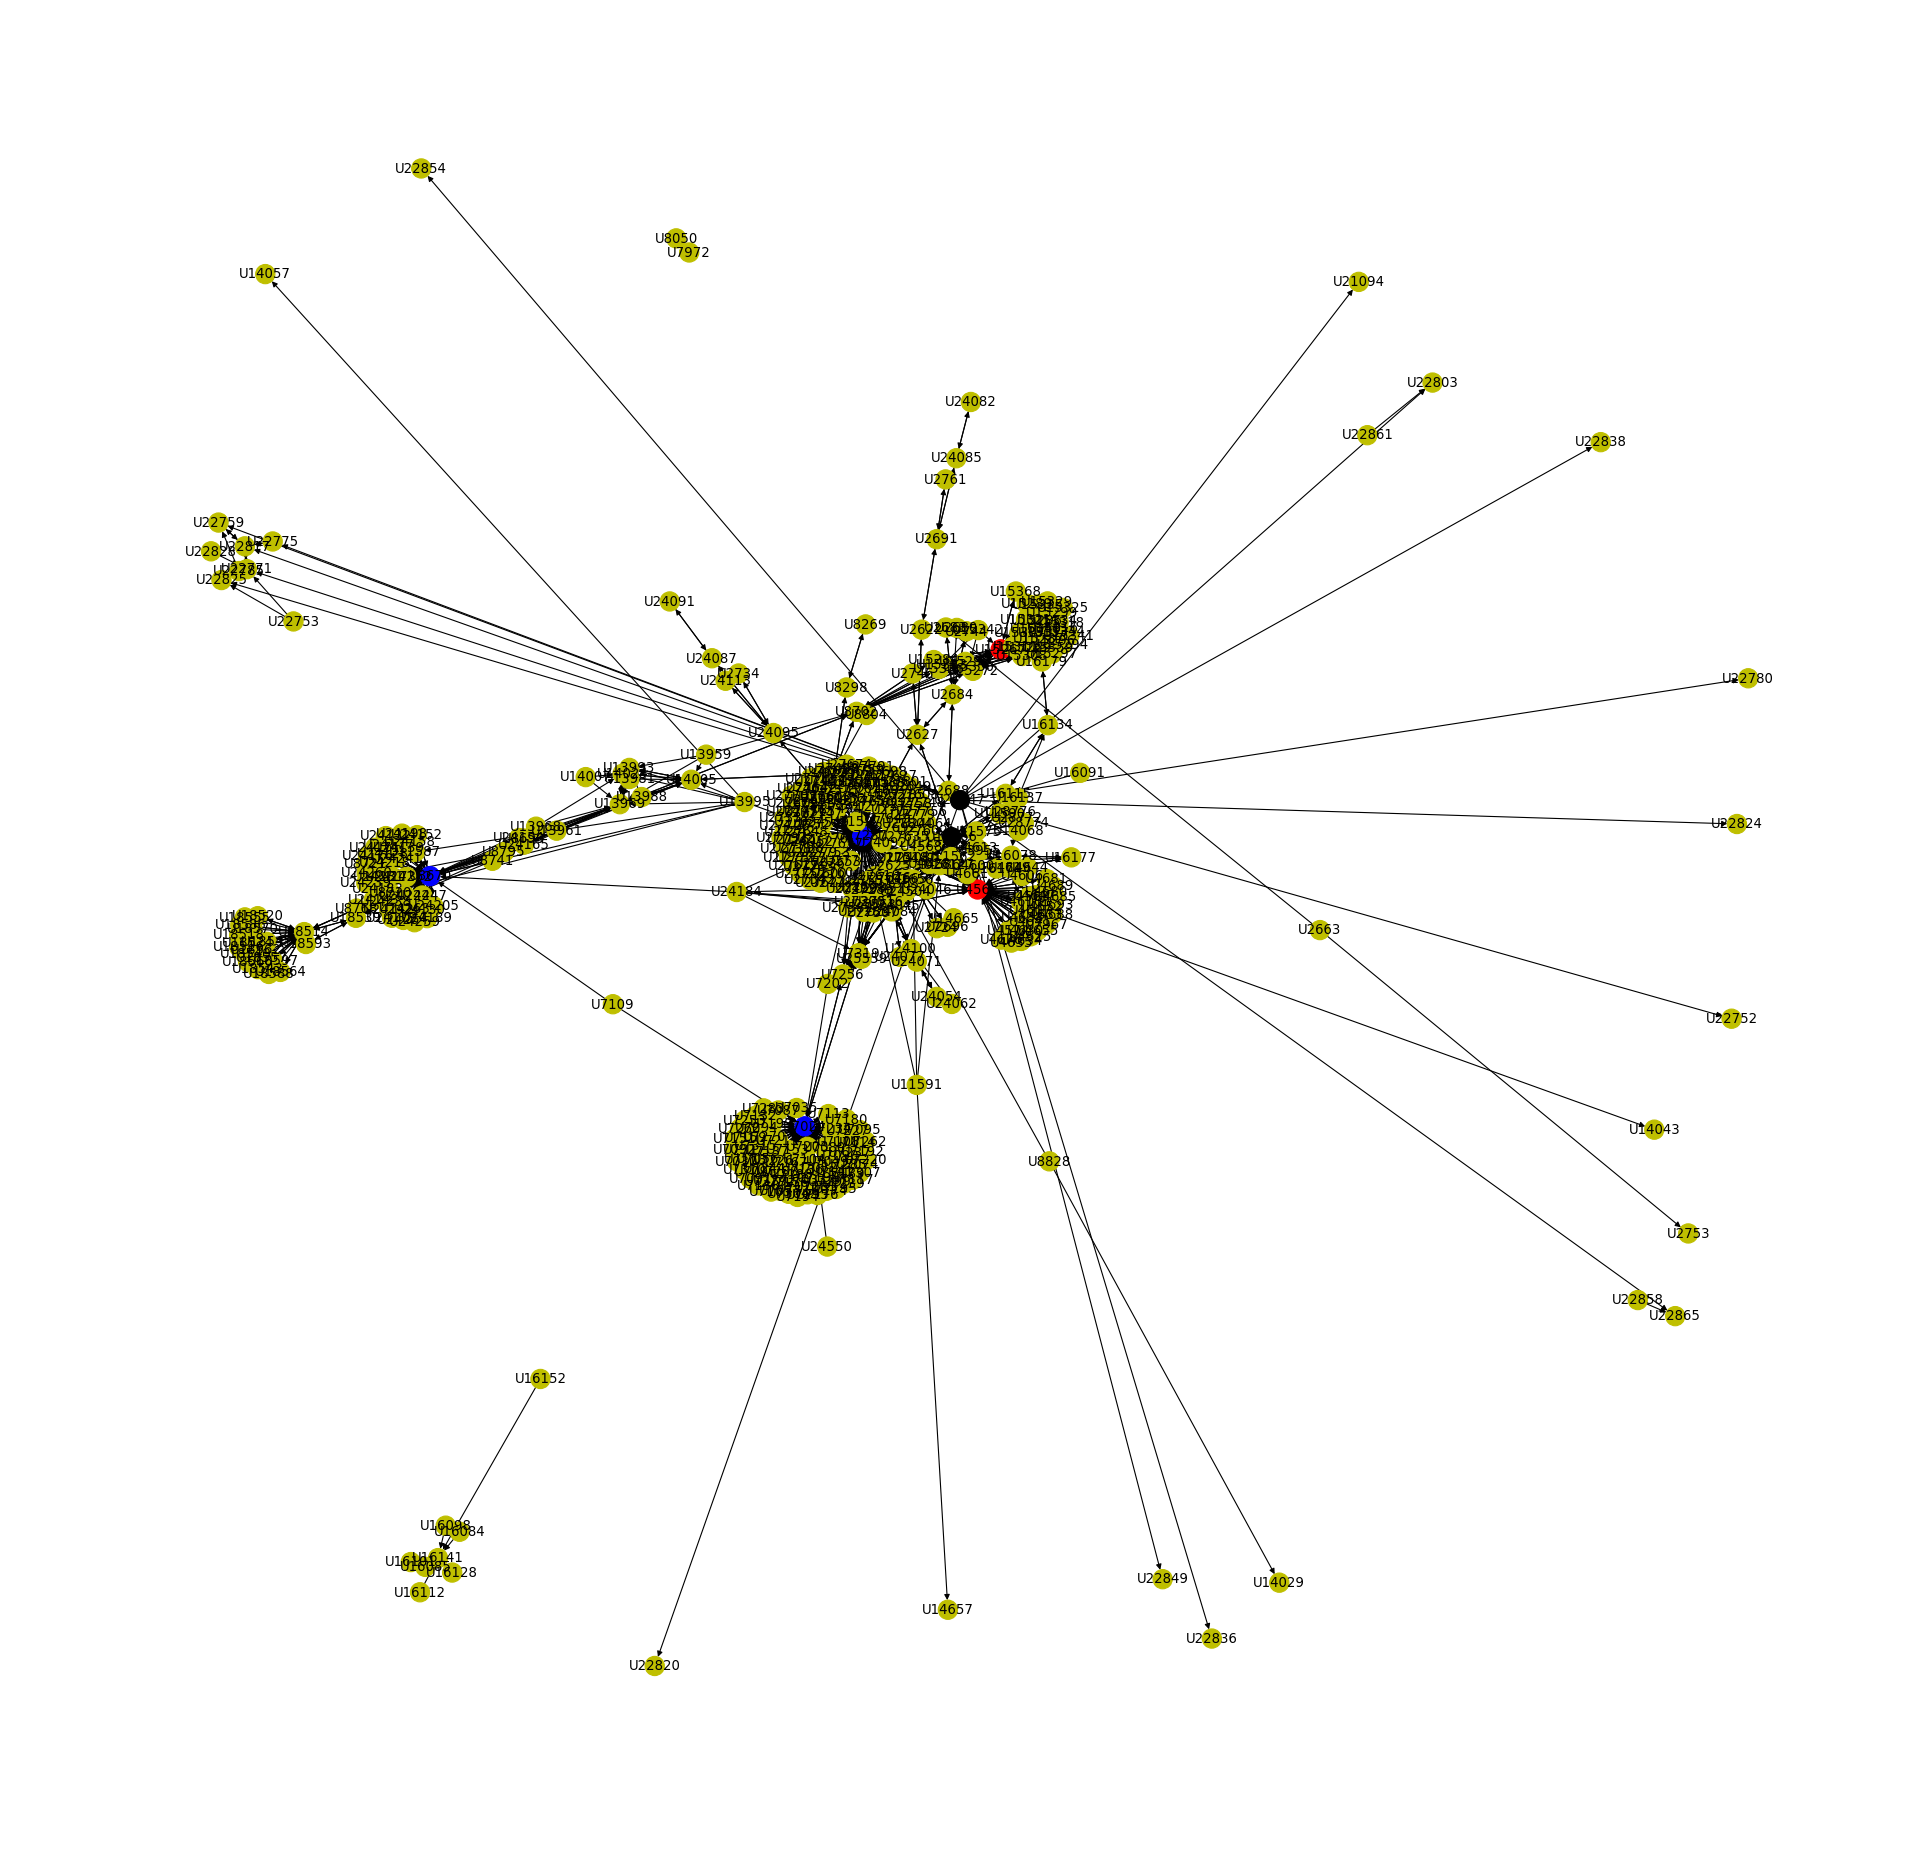

In [443]:
# full-fill the missing value and make a new graph for the Bay Area
from collections import ChainMap

pre1,pre2,pre3 = prediction_degree_class()
prediction_location = ChainMap(pre1,pre2,pre3)
print('high degree class')
proba1 = testLocation(pre1)/100
print('\n\nmid degree class')
proba2 = testLocation(pre2)/100
print('\n\nlow degree class')
proba3 = testLocation(pre3)/100
dic1 = ChainMap(location,prediction_location)

emp_noValues = []
for n in G:
    if n not in prediction_location or n not in location:
        emp_noValues.append(n)


# prediction_location_for_novalues = naive_method(dic1,G,emp_noValues)
# prediction_all = ChainMap(prediction_location,prediction_location_for_novalues)

prediction_all = ChainMap(prediction_location) 

loc_matched,loc_key_matched = strMatch('bay',location)
loc_matched_pred1,loc_key_matched_pred1 = strMatch('bay',pre1)
loc_matched_pred2,loc_key_matched_pred2 = strMatch('bay',pre2)
loc_matched_pred2,loc_key_matched_pred3 = strMatch('bay',pre3)
loc_key_matched_pred = loc_key_matched_pred1 + loc_key_matched_pred2 + loc_key_matched_pred3
loc_key_all = loc_key_matched + loc_key_matched_pred
edges = []
G_Bay = nx.DiGraph()

influence_matrix = {}

for i in G:
    influence_matrix[i] = 0
for k in G:
    for ngb in G[k]:
        if ngb in loc_key_matched and ngb not in loc_key_matched_pred:
            edges.append((k,ngb,{'weight':1}))
            influence_matrix[k] += 1
        elif ngb not in loc_key_matched and ngb in loc_key_matched_pred1:    
            edges.append((k,ngb,{'weight':proba1}))
            influence_matrix[k] += proba1
        elif ngb not in loc_key_matched and ngb in loc_key_matched_pred2:
            edges.append((k,ngb,{'weight':proba2}))
            influence_matrix[k] += proba2
        elif ngb not in loc_key_matched and ngb in loc_key_matched_pred3:
            edges.append((k,ngb,{'weight':proba3}))
            influence_matrix[k] += proba3
G_Bay.add_edges_from(edges)

influence_list = [(j,i) for i,j in influence_matrix.items()]
influence_list = sorted(influence_list, reverse = True)

pr = {}
pr1 = {}

for i in G_Bay:
    pr[i] = G_Bay.out_degree(i)

pr_list = [(n_val,n_key) for n_key,n_val in pr.items()]
pr_list = sorted(pr_list,reverse= True)

vals = {}
keys = []
a = 5
for i in range(0,a):
    vals[pr_list[i][1]] = float(pr_list[i][0])
    keys.append(pr_list[i][1])
    G_Bay.node[pr_list[i][1]]['color'] = 'r'
print('\n\n Out_degree top 5')
print(keys)
for i in range(a,len(G_Bay)):
    vals[pr_list[i][1]] = float(pr_list[i][0])
    keys.append(pr_list[i][1])
    G_Bay.node[pr_list[i][1]]['color'] = 'y'
    
for i in range(a):
    if influence_list[i][1] in G_Bay.nodes() and G_Bay.node[influence_list[i][1]]['color'] == 'r':
        G_Bay.node[influence_list[i][1]]['color'] = 'blue'
    elif influence_list[i][1] in G_Bay.nodes() and G_Bay.node[influence_list[i][1]]['color'] != 'r':
        G_Bay.node[influence_list[i][1]]['color'] = 'black'
    elif influence_list[i][1] not in G_Bay.nodes():
        print(influence_list[i])
print('influence top 5')
print(influence_list[:10])

drawGraph(G_Bay)

[(22, 'U27287'), (21, 'U7024'), (7, 'U11566'), (5, 'U3955'), (5, 'U27475')]
[(100.67153846153843, 'U27287'), (49.988141025641035, 'U7024'), (25.852371794871797, 'U8670'), (24.176089743589745, 'U11566'), (23.34602564102564, 'U22747')]
22
21
2
7
3
drawing the Graph, be patient please ^-^


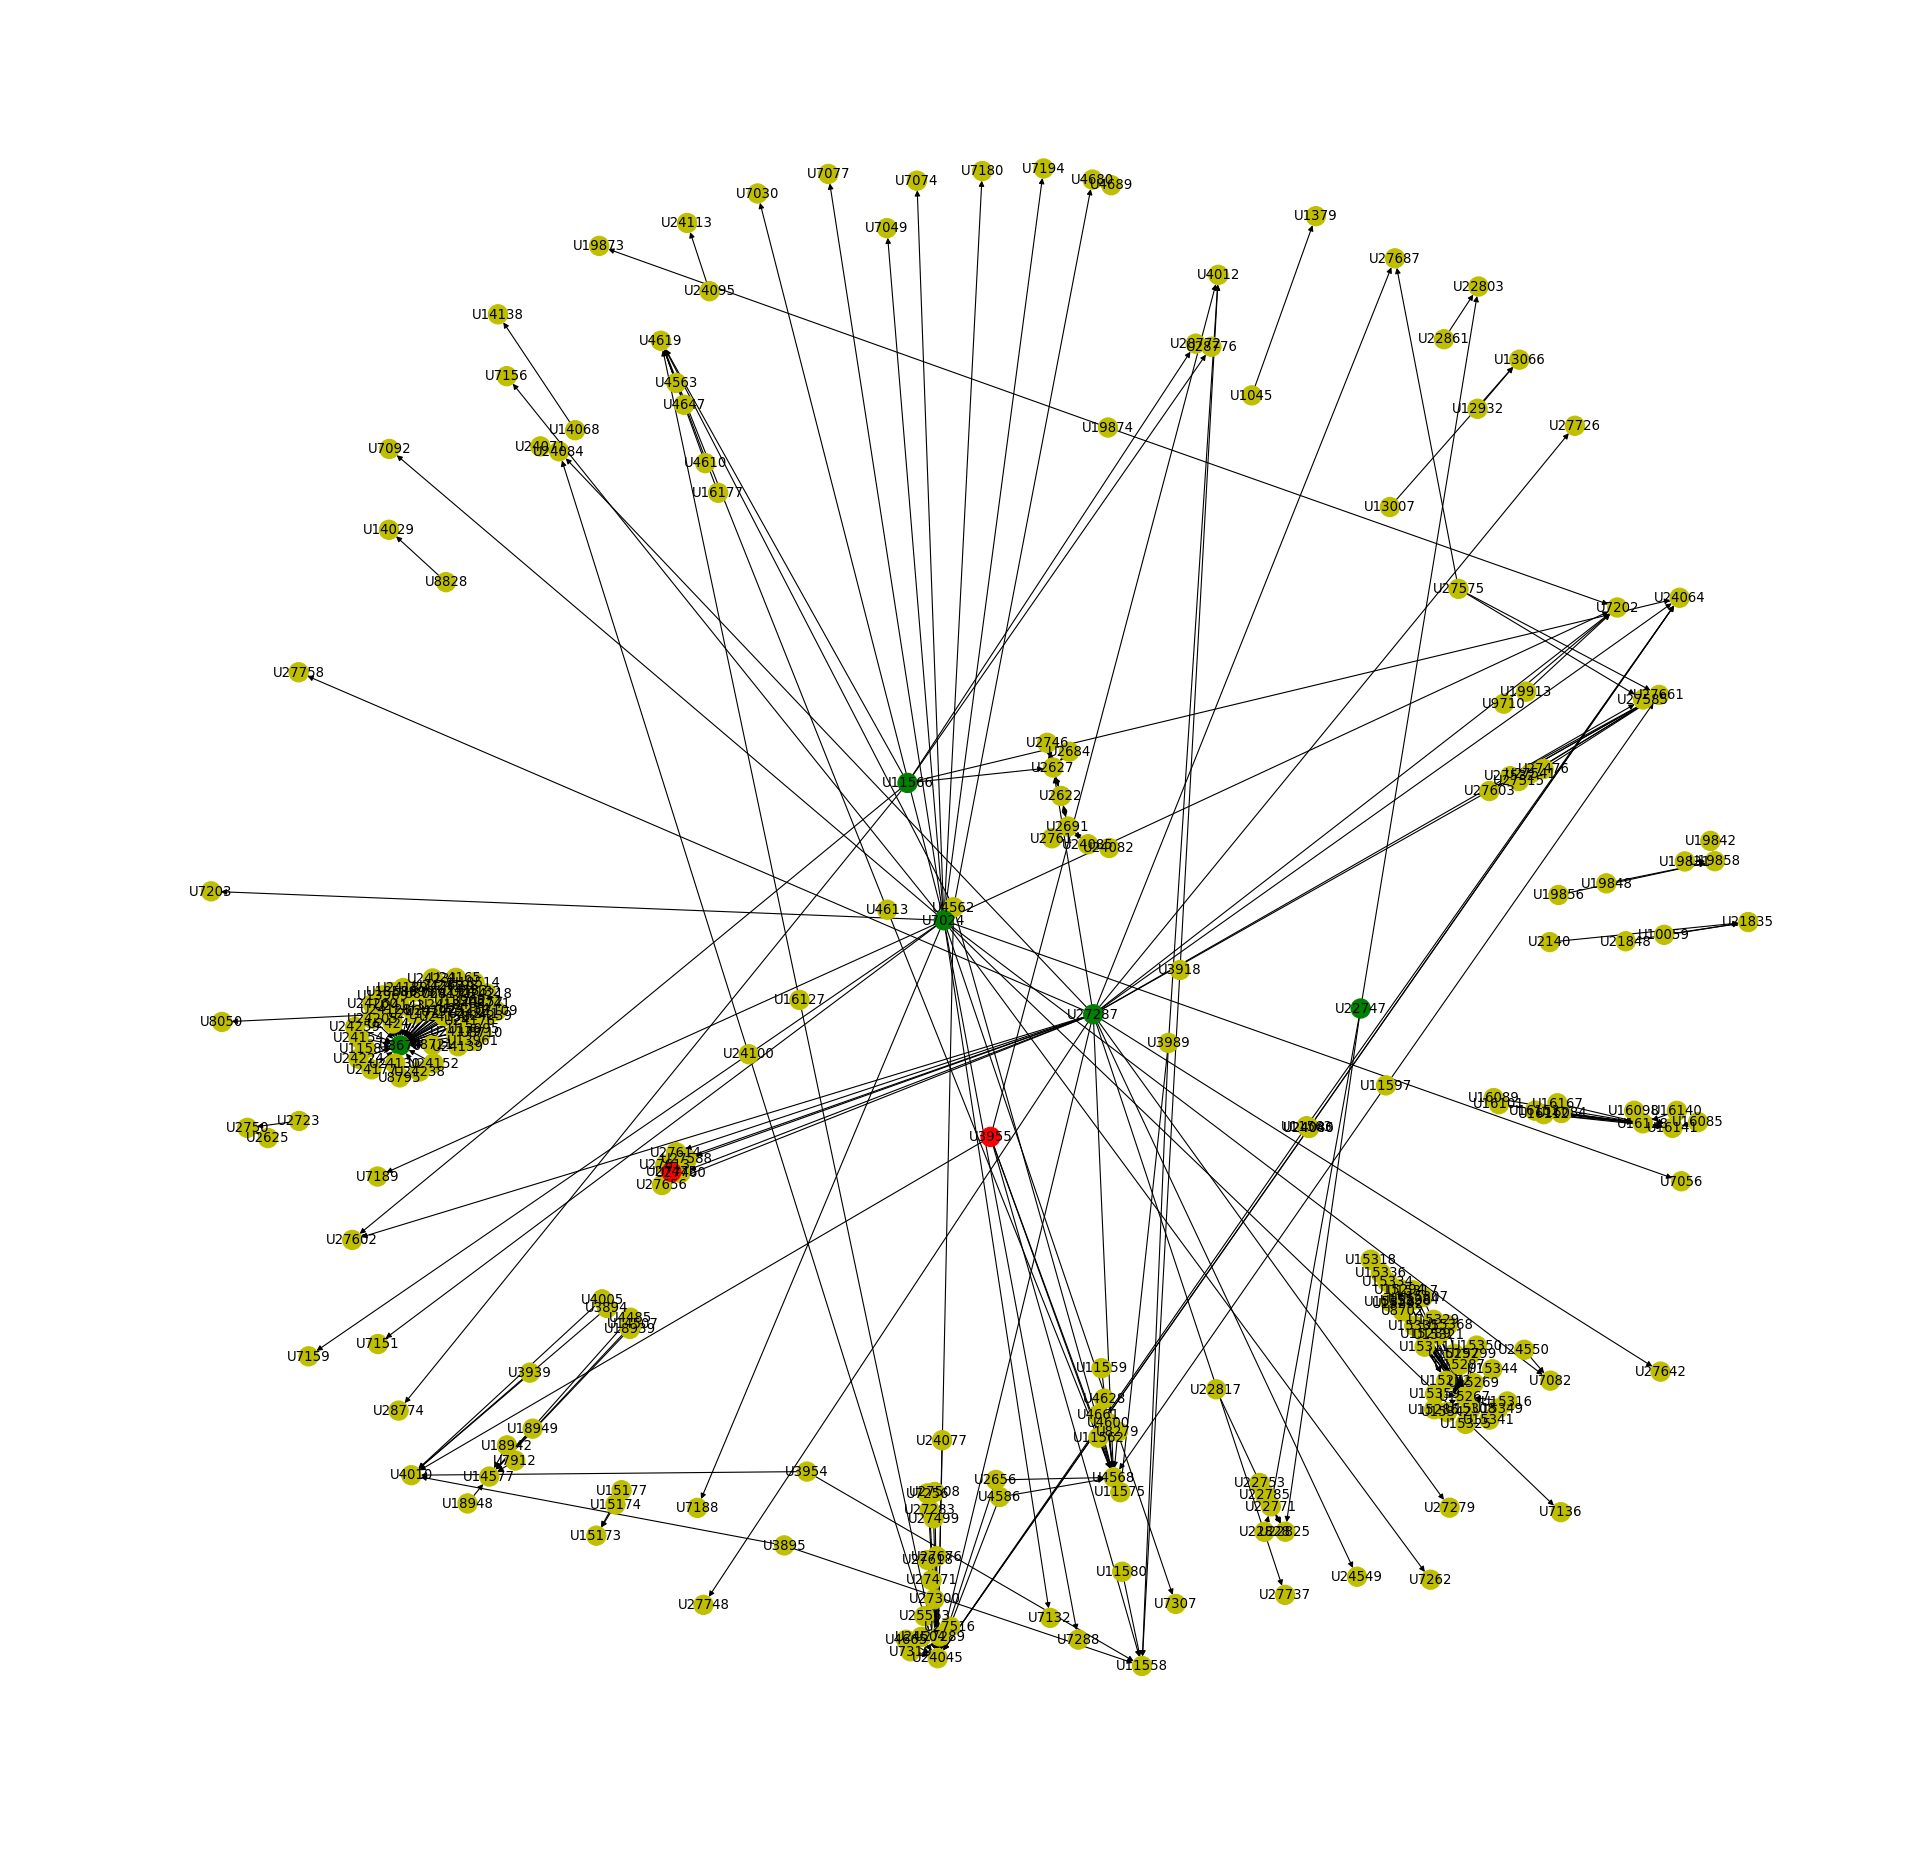

In [442]:
# Test with the real data 
with open('mediumlocation.pickle', 'rb') as handle:
    groundtruth_location = pickle.load(handle)
real_loc_matched,real_loc_key_matched = strMatch('bay',groundtruth_location)
edges = []
G_Bay_real = nx.DiGraph()

for k in G:
    for ngb in G[k]:
        if ngb in real_loc_key_matched:
            edges.append((k,ngb,{'weight':1}))
G_Bay_real.add_edges_from(edges)
pr = {}
for i in G_Bay_real:
    pr[i] = G_Bay_real.out_degree(i)
pr_list = [(n_val,n_key) for n_key,n_val in pr.items()]
pr_list = sorted(pr_list,reverse= True)

real_vals = {}
real_keys = []
alpha = 5
for i in range(0,alpha):
    real_vals[pr_list[i][1]] = float(pr_list[i][0])
    real_keys.append(pr_list[i][1])
    G_Bay_real.node[pr_list[i][1]]['color'] = 'r'
print(pr_list[:5])
for i in range(alpha,len(G_Bay_real)):
    real_vals[pr_list[i][1]] = float(pr_list[i][0])
    real_keys.append(pr_list[i][1])
    G_Bay_real.node[pr_list[i][1]]['color'] = 'y'

l2 = influence_list[:5]   
print(l2)
for i in l2:
    print(pr[i[1]])
for i in l2:
    i = i[1]
    if i in real_keys and i in G_Bay_real:
        G_Bay_real.node[i]['color'] = 'green'
    else:
        G_Bay_real.node[i]['color'] = 'blue'
    
drawGraph(G_Bay_real)


In [56]:
for i in G['U11566']:
    if i in prediction_all:
        print(i,prediction_all[i])

U4665 ['urbana-champaign illinois area']
U4613 ['urbana-champaign illinois area']
U2656 ['urbana-champaign illinois area']
U16115 ['urbana-champaign illinois area']
U28776 ['urbana-champaign illinois area']
U2627 ['san francisco bay area']
U28774 ['urbana-champaign illinois area']
U4562 ['urbana-champaign illinois area']
U27287 ['urbana-champaign illinois area']
U4619 ['urbana-champaign illinois area']
U24504 ['urbana-champaign illinois area']
U27602 ['urbana-champaign illinois area']
U4586 ['urbana-champaign illinois area']


In [ ]:
### Data mining location:
# define that who lives in BAY Area , the location number is 1 who not is distributed by 0:

loc_st = {}
loc_normalized = {}
for i in location:
    if location[i]!=[]:
        loc_normalized[i] = 0
    for loc in location[i]:
        if loc.find('bay')>0:
            loc_normalized[i]=1
        if loc not in loc_st:
            loc_st[loc] = [i]
        if loc in loc_st:
            loc_st[loc].append(i)
len(loc_normalized)       


In [ ]:
for i in loc_st:
    if i.find('bay')>0:
        print(i + '  has      %d   people' % len(loc_st[i]))


In [123]:
# Bay livers' employement and college
no_col = []
no_emp = []
col_st = {}
col_normalized = {}
emp_st = {}
emp_normalized = {}
for i in loc_st:
    if i.find('bay')>0:
        print(i + '  has      %d   people' % len(loc_st[i]))
        for k in loc_st[i]:
            if k in employer:
                for e in employer[k]:
                    if e not in emp_st:
                        emp_st[e] = [k]
                    else:
                        emp_st[e].append(k)
                print(employer[k])
            else: no_emp.append(k)   
            if k in college:
                for e in college[k]:
                    if e not in col_st:
                        col_st[e] = [k]
                    else:
                        col_st[e].append(k)
                print(college[k])
            else: no_col.append(k)
no_col_emp = [v for v in no_col if v in no_emp]
no_col_emp

san francisco bay area  has      25   people
['uc berkeley', 'msr redmond', 'msr cambridge', 'university of waterloo', 'information engineers and consultants bangladesh ltd.']
['bangladesh university of engineering and technology']
['uc berkeley', 'msr redmond', 'msr cambridge', 'university of waterloo', 'information engineers and consultants bangladesh ltd.']
['bangladesh university of engineering and technology']
['apple', 'university of pittsburgh school of information science', 'haoban digital co.']
['east china normal university software engineering institute']
['google', 'at&amp;t labs inc.', 'university of michigan']
['shanghai jiao tong university']
['google']
['tongji university']
['yelp.com']
['apple', 'canesta', 'netease']
['tsinghua university']
['google']
['apple inc.', 'university of texas at austin', 'infinera', 'texas instruments']
['birla institute of technology and science']
['stanford university']
['stanford university']
['ca technologies']
['yahoo! labs', 'idiap res

['U7056', 'U7159']

In [ ]:
col_st

In [ ]:
for i in G:
    G.nodes[i]['color'] = 'y'
a,b = strMatch('bay',location)
for i in b:
    G.nodes[i]['color'] = 'r'
    
drawGraph(G.subgraph(b))

In [360]:
loc_st

{'albany new york area': ['U1220', 'U1220', 'U16085'],
 'athens georgia area': ['U1199', 'U1199'],
 'austin texas area': ['U1108', 'U1108', 'U2631', 'U27475', 'U7377'],
 'baltimore maryland area': ['U1417', 'U1417'],
 'bangladesh': ['U15329', 'U15329', 'U15299', 'U15307', 'U15311'],
 'beijing city china': ['U11609',
  'U11609',
  'U4647',
  'U16101',
  'U11597',
  'U18983',
  'U3989',
  'U27494'],
 'bengaluru area india': ['U22859', 'U22859', 'U22828'],
 'birmingham alabama area': ['U15289', 'U15289'],
 'bloomington normal illinois area': ['U13005', 'U13005', 'U14136', 'U18932'],
 'bologna area italy': ['U8804', 'U8804'],
 'british columbia canada': ['U15334', 'U15334'],
 'chandigarh area india': ['U15974', 'U15974'],
 'charlotte north carolina area': ['U24128', 'U24128'],
 'chennai area india': ['U7174', 'U7174'],
 'china': ['U16112',
  'U16112',
  'U24062',
  'U3914',
  'U3909',
  'U27763',
  'U2663',
  'U18964',
  'U4448',
  'U27777'],
 'cincinnati area': ['U9689', 'U9689'],
 'colum

In [ ]:

def find_wrong_prediction(pre,pre2):
    for i in pre:
        if pre[i]!=groundtruth_location[i]:
            print(i,pre[i],pre2[i])
            print('real: ',groundtruth_location[i])
            for k in G[i]:
                if k in groundtruth_location:
                    print(i,'neighbors ',k,' lives',groundtruth_location[k])
                    


pre = prediction_by_community(location,empty_nodes,G1)
emp = [v for v in pre]
pre2 = naive_method(location,G1,empty_nodes)
find_wrong_prediction(pre,pre2)
testLocation(pre)


In [ ]:
len(pre)

In [ ]:
nd = []
for i in empty_nodes:
    if i not in pre:
        nd.append(i)
pre3 = naive_method(location,G,nd)
testLocation(pre3)

In [ ]:
for i in G:
    G.nodes[i]['color'] = 'y'
a,b = strMatch('bay',l)
for i in b:
    G.nodes[i]['color'] = 'r'
testLocation({v:['san francisco bay area'] for v in b})
drawGraph(G.subgraph(b))

In [ ]:
testCollege(prediction_by_community(college,empty_nodes,G1,rst_com))
testEmployer(prediction_by_community(employer,empty_nodes,G1,rst_com))
testLocation(prediction_by_community(location,empty_nodes,G1,rst_com))

In [459]:
a=[]
for i in groundtruth_location:
    if groundtruth_location[i][0] not in a:
        a.append(groundtruth_location[i][0])
b=[]
for i in location:
    if location[i][0] not in b:
        b.append(location[i][0])
print('%d different adress in the groundtruth_location'%len(a))
print('%d different adress in the location'%len(b))

135 different adress in the groundtruth_location
89 different adress in the location


In [455]:
len(a)

135

89

In [ ]:
l_pre = []
m_pre = []
h_pre = []
for node in pre:
    if node in node_high_dgr:
        h_pre.append(node)
    elif node in node_mid_dgr:
        m_pre.append(node)
    elif node in node_low_dgr:
        l_pre.append(node)


In [ ]:
print(len(l_pre),'  ',len(node_low_dgr))
print(len(m_pre),'  ',len(node_mid_dgr))
print(len(h_pre),'  ',len(node_high_dgr))


In [ ]:
# low degree node neighbors are 
i = 0
j = 0
k = 0
visited = []
for node in node_low_dgr:
    
    for n in G[node]:
        if n in node_low_dgr :
            i += 1
        elif n in node_mid_dgr :
            j += 1
        elif n in node_high_dgr:
            k += 1 
        visited.append(n)
print(i,j,k)

In [ ]:
i = 0
j = 0
k = 0
visited = []
for node in node_mid_dgr:
    
    for n in G[node]:
        if n in node_low_dgr:
            i += 1
        elif n in node_mid_dgr:
            j += 1
        elif n in node_high_dgr:
            k += 1 
        visited.append(n)
print(i,j,k)

In [ ]:
i = 0
j = 0
k = 0
visited = []
for node in node_high_dgr:
    
    for n in G[node]:
        if n in node_low_dgr :
            i += 1
        elif n in node_mid_dgr:
            j += 1
        elif n in node_high_dgr :
            k += 1 
        visited.append(n)
print(i,j,k)

In [ ]:
import sys
import time

  
for k in range(3,7):
        print ("############# k值: %d ################" % k)
        start_time = time.clock()
        rst_com = find_community(G,k)
        end_time = time.clock()
        print ("计算耗时(秒)：%.3f" % (end_time-start_time))
        print ("生成的社区数：%d" % len(rst_com))
        print(rst_com)

In [ ]:
loc_st={}
for i in groundtruth_location:
    for j in groundtruth_location[i]:
        if j not in loc_st:
            loc_st[j] = [i]
        else:
            loc_st[j].append(i)
loc_st = sorted(loc_st.items(),key = lambda t:len(t[1]),reverse=True)
for i in range(10):
    print(loc_st[i][0],len(loc_st[i][1]))

In [356]:
import pandas as pd
col_normalized = {}
col_list = []
emp_normalized = {}
emp_list=[]
loc_st = {}
loc_normalized = {}
for i in college:
    col = college[i][0]
    if col not in col_list:
        col_list.append(col)
    col_normalized[i] = col_list.index(col)
    
for i in employer:
    emp = employer[i][0]
    if emp not in emp_list:
        emp_list.append(emp)
    emp_normalized[i] = emp_list.index(emp)

for i in location:
    if location[i]!=[]:
        loc_normalized[i] = 0
    for loc in location[i]:
        if loc.find('bay')>0:
            loc_normalized[i]=1
        if loc not in loc_st:
            loc_st[loc] = [i]
        if loc in loc_st:
            loc_st[loc].append(i)   

index = 0
for i in G:
    index += len(G[i])
idx = [v for v in range(index)]

df_all = pd.DataFrame(index=idx,columns = ['id','location','college','employer','ngb_id','ngb_location','ngb_college','ngb_employer'])

In [362]:
print('there are %d different locations'%len(loc_st))
print('there are %d different colleges'%len(col_list))
print('there are %d different employers'%len(emp_list))

there are 89 different locations
there are 100 different colleges
there are 227 different employers


In [27]:
index = 0
for i in G:
    for j in G[i]:
        df_all['id'][index] = i 
        df_all['ngb_id'][index] = j
        if i in location and location[i]!=[]:
            df_all['location'][index] = loc_normalized[i]
        if i in college and college[i] != []:
            df_all['college'][index] = col_normalized[i]
        if i in employer and employer[i]!=[]:
            df_all['employer'][index] = emp_normalized[i]
        if j in location and location[j]!=[]:
            df_all['ngb_location'][index] = loc_normalized[j]
        if j in college and college[j] != []:
            df_all['ngb_college'][index] = col_normalized[j]
        if j in employer and employer[j]!=[]:
            df_all['ngb_employer'][index] = emp_normalized[j]
    
        index += 1
            
df_all

id location college employer  ngb_id ngb_location ngb_college  \
0     U27476      NaN     NaN      NaN  U27661            1           7   
1     U27476      NaN     NaN      NaN  U27532          NaN         NaN   
2     U27476      NaN     NaN      NaN  U27515          NaN         NaN   
3     U27476      NaN     NaN      NaN  U27477          NaN         NaN   
4     U27476      NaN     NaN      NaN  U27541            0          51   
5     U27476      NaN     NaN      NaN  U27525          NaN         NaN   
6     U27476      NaN     NaN      NaN  U27634          NaN         NaN   
7     U27476      NaN     NaN      NaN  U27287          NaN         NaN   
8      U4665      NaN     NaN      NaN  U11566          NaN         NaN   
9      U4665      NaN     NaN      NaN  U27516          NaN         NaN   
10     U4665      NaN     NaN      NaN  U24504          NaN         NaN   
11     U4665      NaN     NaN      NaN   U4562          NaN         NaN   
12     U4665      NaN     NaN      NaN  U27676          NaN         NaN   
13     U4665      NaN     NaN      NaN  U27471          NaN         NaN   
14     U4665      NaN     NaN      NaN  U25563          NaN         NaN   
15     U4665      NaN     NaN      NaN  U27287          NaN         NaN   
16     U4665      NaN     NaN      NaN  U24045          NaN         NaN   
17     U4665      NaN     NaN      NaN  U27557          NaN         NaN   
18     U1313        0       0        0   U1359          NaN         NaN   
19     U1313        0       0        0   U1044          NaN         NaN   
20     U1313        0       0        0   U1045            0          32   
21     U1313        0       0        0  U10607          NaN         NaN   
22     U8804        0       1        1   U8279          NaN         NaN   
23    U14078      NaN     NaN      NaN  U14068            0           2   
24    U14078      NaN     NaN      NaN  U14088          NaN         NaN   
25    U14078      NaN     NaN      NaN  U14125            0          30   
26    U14078      NaN     NaN      NaN  U14121          NaN         NaN   
27     U9628      NaN     NaN      NaN   U9630            0         NaN   
28     U9628      NaN     NaN      NaN   U9642          NaN         NaN   
29     U9628      NaN     NaN      NaN   U9665            0         NaN   
...      ...      ...     ...      ...     ...          ...         ...   
3164  U10607      NaN     NaN      NaN  U10618          NaN         NaN   
3165  U10607      NaN     NaN      NaN  U25594          NaN         NaN   
3166  U10607      NaN     NaN      NaN   U1055            0          65   
3167   U7189      NaN     NaN      NaN   U7024          NaN         NaN   
3168  U27798      NaN     NaN      NaN  U27287          NaN         NaN   
3169  U14564      NaN     NaN      NaN  U18916            0          18   
3170  U14564      NaN     NaN      NaN  U14526          NaN         NaN   
3171  U14564      NaN     NaN      NaN  U16219          NaN         NaN   
3172  U14564      NaN     NaN      NaN   U4485            0           2   
3173  U14112      NaN     NaN      NaN  U14119          NaN         NaN   
3174  U14112      NaN     NaN      NaN  U14113          NaN         NaN   
3175  U14112      NaN     NaN      NaN  U14068            0           2   
3176   U4586      NaN     NaN      NaN  U11562            0           7   
3177   U4586      NaN     NaN      NaN  U11591            0           2   
3178   U4586      NaN     NaN      NaN   U4613          NaN         NaN   
3179   U4586      NaN     NaN      NaN  U16174          NaN         NaN   
3180   U4586      NaN     NaN      NaN  U24045          NaN         NaN   
3181   U4586      NaN     NaN      NaN   U4628          NaN         NaN   
3182   U4586      NaN     NaN      NaN  U16127            0           2   
3183   U4586      NaN     NaN      NaN   U4562          NaN         NaN   
3184   U4586      NaN     NaN      NaN  U27287          NaN         NaN   
3185   U4586      NaN     NaN      

In [67]:
df_a = df_all[df_all.location.notna()]
df_a = df_a[df_a.ngb_college.notna()]
df_a = df_a[df_a.ngb_location.notna()]
df_a = df_a[df_a.ngb_employer.notna()]

id location college employer  ngb_id ngb_location ngb_college  \
20     U1313        0       0        0   U1045            0          32   
38    U22859        0       4        4  U22747            0           2   
39     U1417        0     NaN        5   U1045            0          32   
41    U25611        0       5        6   U1175            0          70   
42    U25611        0       5        6   U1045            0          32   
47     U3895        0       7        7  U11564            0           7   
50     U3895        0       7        7   U3894            0           7   
52     U3895        0       7        7   U4005            0           7   
55    U13005        0       2        8  U12969            0           2   
57     U2620        0     NaN      NaN   U2649            0          66   
61     U5976        0       3       80   U6000            0          62   
81     U9140        0       8        9   U9149            0          85   
82     U9140        0       8        9   U9126            0          62   
86    U16112        0     NaN       10  U16141            1          34   
119   U15272        1       9       12  U15292            0           9   
120   U15272        1       9       12  U15311            0           9   
122    U3933        0       7       13   U3989            0           7   
124    U3933        0       7       13   U3919            0          28   
138   U11562        0       7        9  U11563            0          42   
139   U11562        0       7        9   U4568            1           7   
146   U15292        0       9        9  U15272            1           9   
149   U15292        0       9        9  U15333            0           2   
175   U14498        0      69       15  U14500            0           2   
193   U12969        0       2       18  U13005            0           2   
198    U2180        0       2      221   U2140            0           2   
200    U2180        0       2      221   U2136            0           2   
219   U27283        0       2       21  U24184            0           2   
241   U25619        0      17       22   U1045            0          32   
259   U11591        0       2       25   U9126            0          62   
260   U11591        0       2       25  U14665            0           6   
...      ...      ...     ...      ...     ...          ...         ...   
2871   U4448        0     NaN      NaN   U4457            0          42   
2873   U4448        0     NaN      NaN   U4485            0           2   
2902  U15342        0     NaN        9  U15292            0           9   
2903  U15342        0     NaN        9  U15289            0           9   
2907  U15342        0     NaN        9  U15333            0           2   
2918  U16085        0     NaN      214  U16141            1          34   
2948  U15286        0     NaN      215  U15334            0          25   
2953   U4005        0       7      217   U3895            0           7   
2956   U4005        0       7      217   U3894            0           7   
3006  U14123        0      95      218  U15168            0           2   
3009  U14123        0      95      218  U14068            0           2   
3029   U9711        0       2      220   U9660            0           2   
3030   U9711        0       2      220   U9689            0           2   
3038  U22753        0      86      189  U22771            1          86   
3040  U22753        0      86      189  U22747            0           2   
3047   U7402        0       2      223   U7347            0           2   
3103  U14007        0     NaN        9  U13988            0          26   
3106  U14007        0     NaN        9  U13961            0          26   
3108  U14007        0     NaN        9  U13968            0          48   
3109  U14007        0     NaN        9  U13981            0          26   
3110  U14007        0     NaN        9  U13959            0          26   
3112  U14007        0     NaN      

In [76]:
df_train = df_a[50:]
df_cv = df_a[:50]

id location college employer  ngb_id ngb_location ngb_college  \
20    U1313        0       0        0   U1045            0          32   
38   U22859        0       4        4  U22747            0           2   
39    U1417        0     NaN        5   U1045            0          32   
41   U25611        0       5        6   U1175            0          70   
42   U25611        0       5        6   U1045            0          32   
47    U3895        0       7        7  U11564            0           7   
50    U3895        0       7        7   U3894            0           7   
52    U3895        0       7        7   U4005            0           7   
55   U13005        0       2        8  U12969            0           2   
57    U2620        0     NaN      NaN   U2649            0          66   
61    U5976        0       3       80   U6000            0          62   
81    U9140        0       8        9   U9149            0          85   
82    U9140        0       8        9   U9126            0          62   
86   U16112        0     NaN       10  U16141            1          34   
119  U15272        1       9       12  U15292            0           9   
120  U15272        1       9       12  U15311            0           9   
122   U3933        0       7       13   U3989            0           7   
124   U3933        0       7       13   U3919            0          28   
138  U11562        0       7        9  U11563            0          42   
139  U11562        0       7        9   U4568            1           7   
146  U15292        0       9        9  U15272            1           9   
149  U15292        0       9        9  U15333            0           2   
175  U14498        0      69       15  U14500            0           2   
193  U12969        0       2       18  U13005            0           2   
198   U2180        0       2      221   U2140            0           2   
200   U2180        0       2      221   U2136            0           2   
219  U27283        0       2       21  U24184            0           2   
241  U25619        0      17       22   U1045            0          32   
259  U11591        0       2       25   U9126            0          62   
260  U11591        0       2       25  U14665            0           6   
261  U27585        1      20       26  U27661            1           7   
273   U1441        0      22       27   U1045            0          32   
286   U9149        0      85       94   U9140            0           8   
288   U9149        0      85       94   U9141            0          81   
289  U18934        0     NaN       29   U4485            0           2   
298   U7379        0       2       31  U22747            0           2   
317  U14015        0     NaN       33  U13959            0          26   
319  U14015        0     NaN       33  U13988            0          26   
320  U15329        0      31       34  U15311            0           9   
331  U18981        0     NaN        9   U4485            0           2   
349   U3958        0       7        3  U11564            0           7   
350   U3958        0       7        3   U3909            0          13   
352  U14117        0      27      NaN  U14068            0           2   
354  U24046        0      28       36  U11563            0          42   
365  U11564        0       7       37   U3895            0           7   
366  U11564        0       7       37   U3958            0           7   
405  U11609        0     NaN      NaN  U11562            0           7   
411  U18954        0      99       39   U4485            0           2   
423   U1045        0      32       40   U1313            0           0   
425   U1045        0      32       40  U25611            0           5   

    ngb_employer  
20            40  
38             9  
39            40  
41            40  
42            40  
47            37  
50           137  
52           217  
55            18  
57             2  
61            90  
81    

In [378]:
from sklearn.ensemble import RandomForestRegressor

def set_missing_location(train_x,train_y,cross_x):

    rfr = RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=-1)
    rfr.fit(train_x, train_y)
    predicted = rfr.predict(cross_x)
    pred_y = np.round(predicted)   
    return pred_y, rfr

In [379]:
x = df_train[['ngb_location','ngb_employer','ngb_college']].as_matrix()
y = df_train['location'].as_matrix()
cross_x = df_cv[['ngb_location','ngb_employer','ngb_college']].as_matrix()
cross_y = df_cv['location'].as_matrix()
predicted,rfr = set_missing_location(x,y,cross_x)

In [387]:
a,b = evaluation(predicted,cross_y)
print("Precision of the prediction for cross_validation_set is %f%%" % a)
print("Recall of the prediction for cross_validation_set is %f%%" % b)

Precision of the prediction for cross_validation_set is 94.000000%
Recall of the prediction for cross_validation_set is 100.000000%


In [386]:
def evaluation(pred, trues):
    if len(pred) == len(trues):
        a = [ int(pred[i]) == trues[i] for i in range(len(pred))]
        return sum(a)/len(pred) * 100 , sum(a)/len([v for v in trues if v == 0]) * 100

In [383]:
predicted

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

drawing the Graph, be patient please ^-^


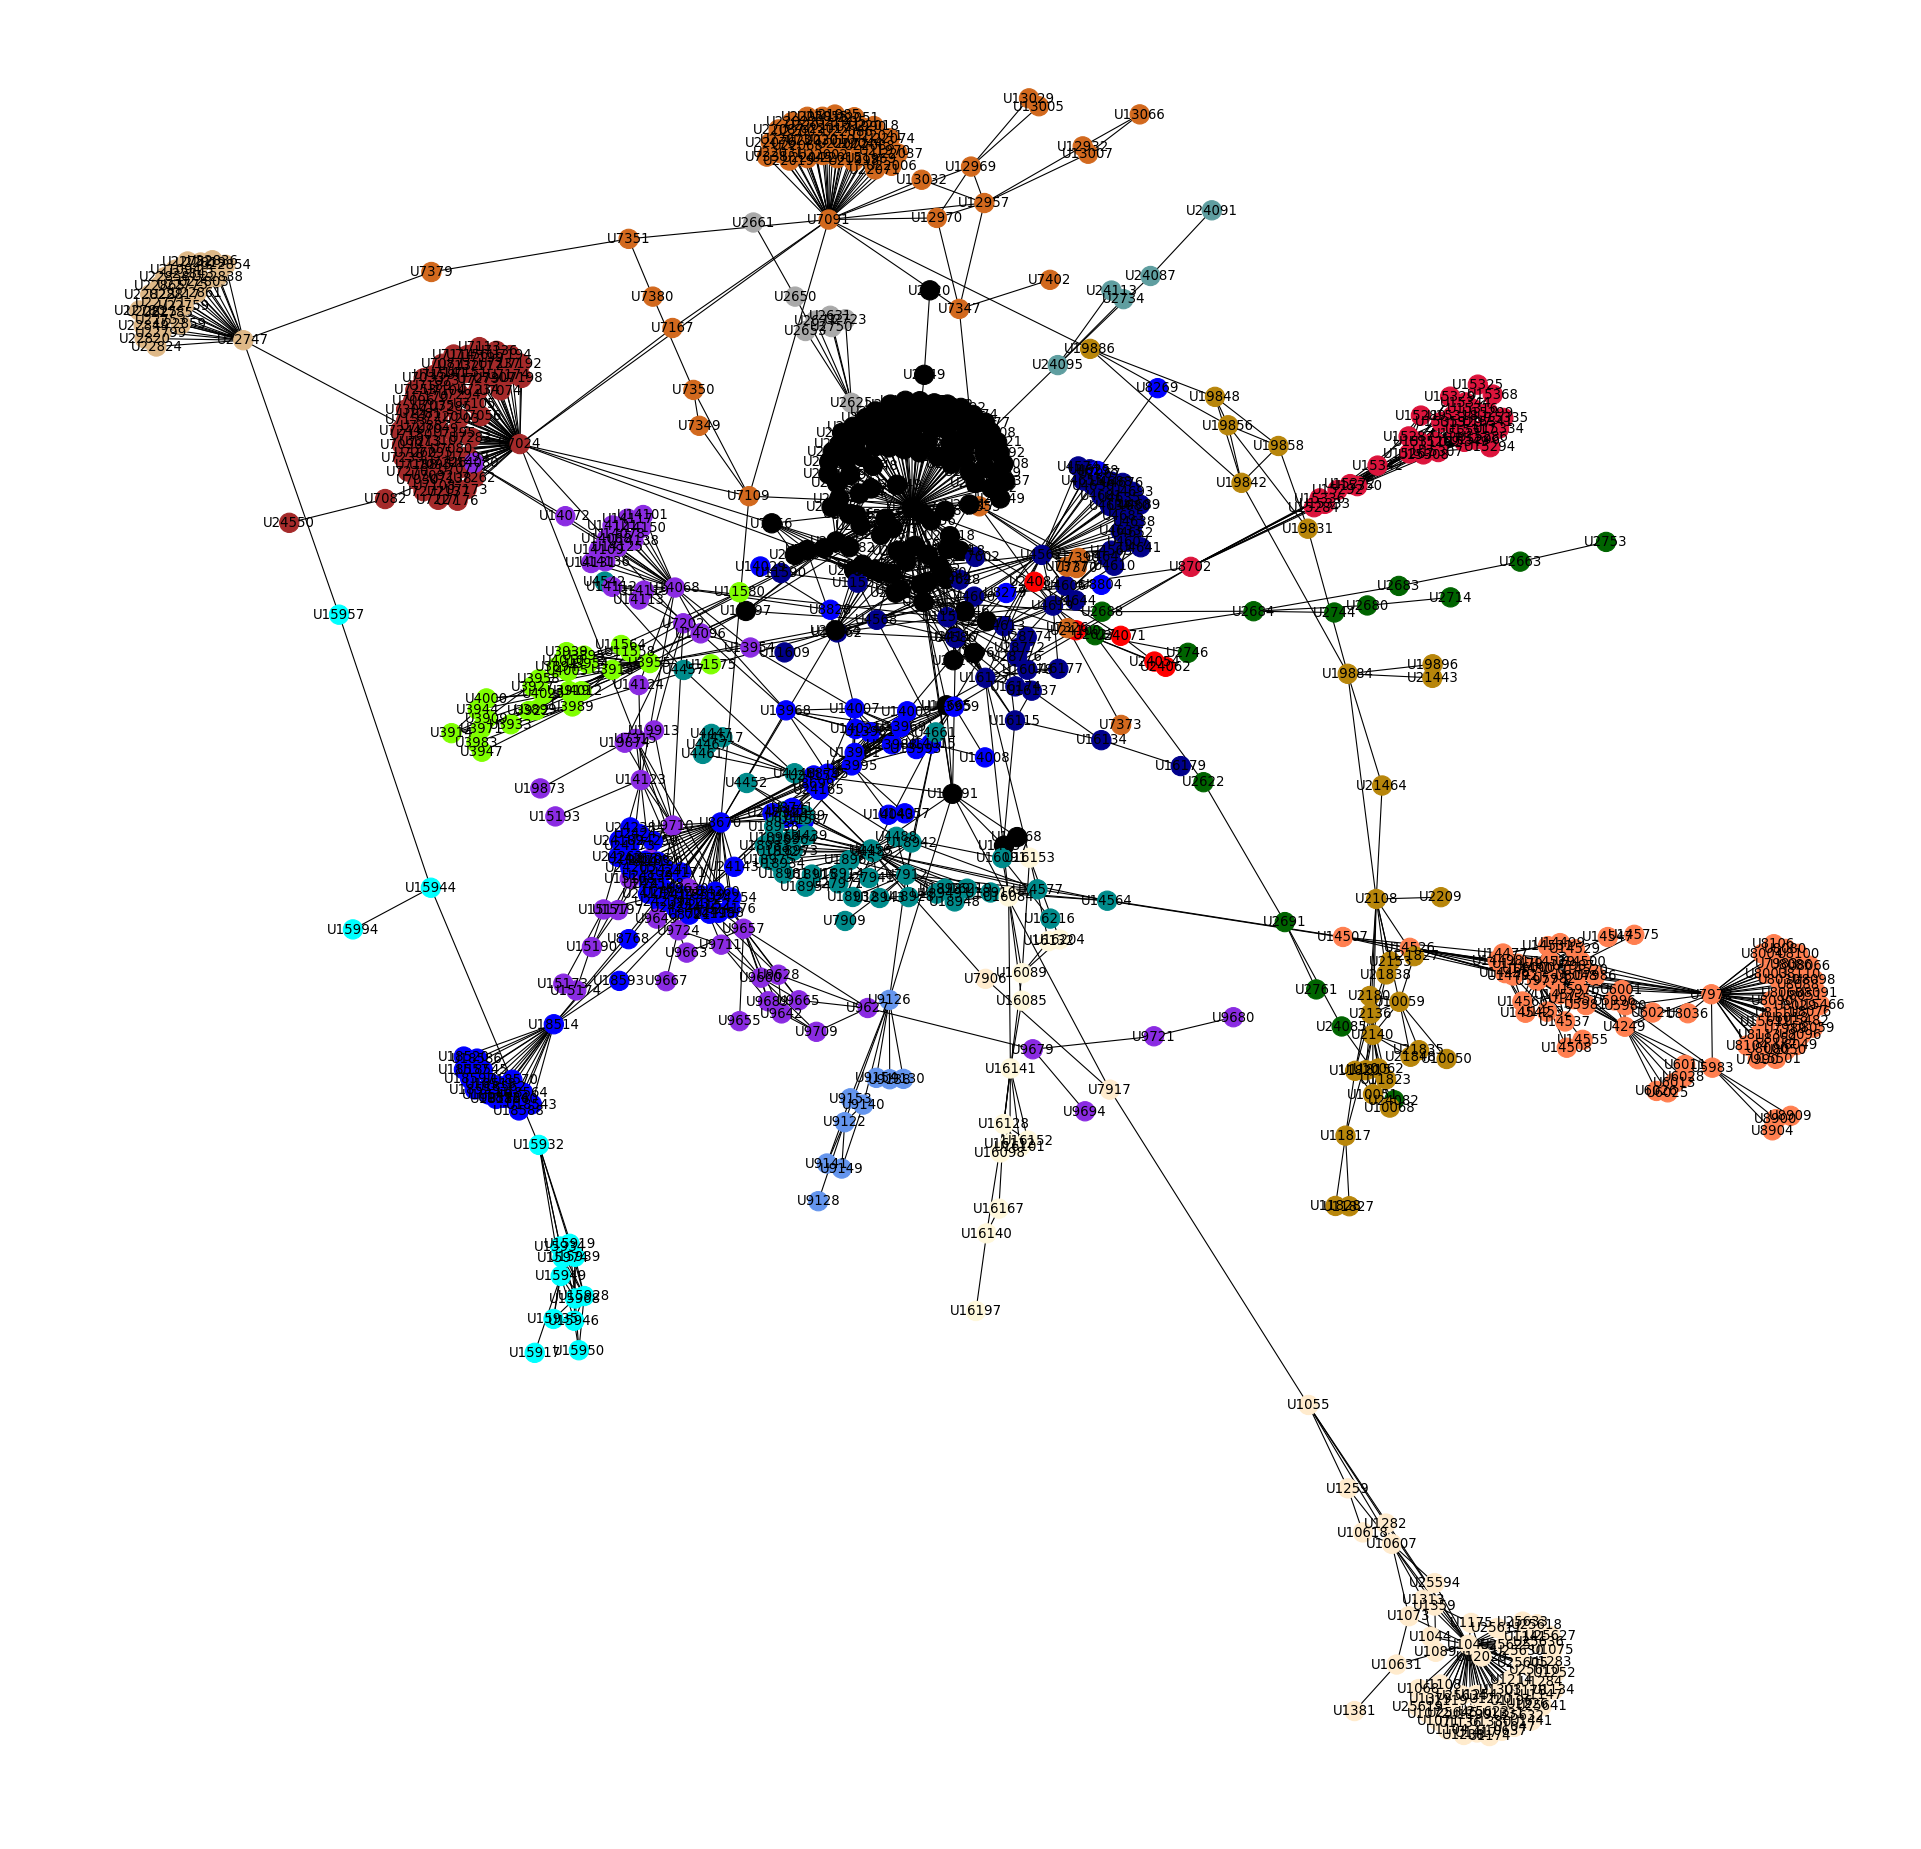

In [279]:
import community
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

#better with karate_graph() as defined in networkx example.
#erdos renyi don't have true community structure
G

#first compute the best partition
rst_com = community.best_partition(G)

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0
color = list(colors.keys())
for i in G:
    G.node[i]['color'] = 'r'
for i in range(max(rst_com.values())):    
    for user in G:
        if rst_com[user] == i:
            G.node[user]['color'] = color[(i+15)%len(colors)]   
drawGraph(G)

In [412]:
rst_com

{'U10050': 16,
 'U10051': 16,
 'U10059': 16,
 'U10062': 16,
 'U10068': 16,
 'U1044': 1,
 'U1045': 1,
 'U1047': 1,
 'U1055': 1,
 'U10607': 1,
 'U10618': 1,
 'U10631': 1,
 'U10637': 1,
 'U1068': 1,
 'U1071': 1,
 'U1072': 1,
 'U1073': 1,
 'U1075': 1,
 'U1089': 1,
 'U1104': 1,
 'U1108': 1,
 'U1119': 1,
 'U1134': 1,
 'U1136': 1,
 'U1141': 1,
 'U1147': 1,
 'U11558': 7,
 'U11559': 14,
 'U11562': 14,
 'U11563': 0,
 'U11564': 7,
 'U11566': 14,
 'U11575': 7,
 'U11580': 7,
 'U11587': 2,
 'U11590': 14,
 'U11591': 0,
 'U11597': 0,
 'U11609': 14,
 'U1174': 1,
 'U1175': 1,
 'U1178': 1,
 'U11815': 16,
 'U11817': 16,
 'U11820': 16,
 'U11823': 16,
 'U11827': 16,
 'U11828': 16,
 'U1196': 1,
 'U1199': 1,
 'U12020': 1,
 'U1214': 1,
 'U1220': 1,
 'U1226': 1,
 'U1238': 1,
 'U1252': 1,
 'U1254': 1,
 'U1259': 1,
 'U1282': 1,
 'U1283': 1,
 'U1284': 1,
 'U12932': 8,
 'U12957': 8,
 'U12969': 8,
 'U12970': 8,
 'U13005': 8,
 'U13007': 8,
 'U13029': 8,
 'U1303': 1,
 'U13032': 8,
 'U13066': 8,
 'U1313': 1,
 'U1331': 

In [423]:
partition = community.best_partition(G)
rst_com = []

for index in range(max(partition.values())):
    com=[]
    for n in partition:
        if partition[n] == index:
            com.append(n)
    rst_com.append(com)
rst_com = sorted(rst_com, key = lambda t:len(t),reverse = True)

count = 0
for com in rst_com:
    

    print('community '+ str(count+1) +' has '+ str(len(com)) +' people' )
    count+=1
#    for node in com:
#        if node in location:
#            print(location[node])


community 1 has 119 people
community 2 has 82 people
community 3 has 79 people
community 4 has 69 people
community 5 has 64 people
community 6 has 60 people
community 7 has 54 people
community 8 has 48 people
community 9 has 45 people
community 10 has 33 people
community 11 has 31 people
community 12 has 28 people
community 13 has 26 people
community 14 has 15 people
community 15 has 15 people
community 16 has 15 people
community 17 has 10 people
community 18 has 8 people
community 19 has 5 people


In [283]:
for i in location['U10051']:
    print(i)

greater chicago area


In [173]:
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

colors

{'aliceblue': '#F0F8FF',
 'antiquewhite': '#FAEBD7',
 'aqua': '#00FFFF',
 'aquamarine': '#7FFFD4',
 'azure': '#F0FFFF',
 'b': (0, 0, 1),
 'beige': '#F5F5DC',
 'bisque': '#FFE4C4',
 'black': '#000000',
 'blanchedalmond': '#FFEBCD',
 'blue': '#0000FF',
 'blueviolet': '#8A2BE2',
 'brown': '#A52A2A',
 'burlywood': '#DEB887',
 'c': (0, 0.75, 0.75),
 'cadetblue': '#5F9EA0',
 'chartreuse': '#7FFF00',
 'chocolate': '#D2691E',
 'coral': '#FF7F50',
 'cornflowerblue': '#6495ED',
 'cornsilk': '#FFF8DC',
 'crimson': '#DC143C',
 'cyan': '#00FFFF',
 'darkblue': '#00008B',
 'darkcyan': '#008B8B',
 'darkgoldenrod': '#B8860B',
 'darkgray': '#A9A9A9',
 'darkgreen': '#006400',
 'darkgrey': '#A9A9A9',
 'darkkhaki': '#BDB76B',
 'darkmagenta': '#8B008B',
 'darkolivegreen': '#556B2F',
 'darkorange': '#FF8C00',
 'darkorchid': '#9932CC',
 'darkred': '#8B0000',
 'darksalmon': '#E9967A',
 'darkseagreen': '#8FBC8F',
 'darkslateblue': '#483D8B',
 'darkslategray': '#2F4F4F',
 'darkslategrey': '#2F4F4F',
 'darkturquo

In [326]:
degrees = dict(G.degree())
node_high_dgr = []
node_mid_dgr = []
node_low_dgr = []
for i in G:
    if degrees[i] > 10:
        node_high_dgr.append(i)
    elif degrees[i] >= 4 :
        node_mid_dgr.append(i)
    else: 
        node_low_dgr.append(i)
cpt = Counter(degrees.values())
cpt = sorted(cpt.items(),key = lambda t: t[0],reverse = False)

a = prediction_by_community(location,empty_nodes)
testLocation(a)

emp = []
for i in node_high_dgr:
    if i in empty_nodes:
        emp.append(i)
a = prediction_by_community(location,emp)
testLocation(a)

for i in node_mid_dgr:
    if i in empty_nodes:
        emp.append(i)
a = prediction_by_community(location,emp)
testLocation(a)

for i in node_low_dgr:
    if i in empty_nodes:
        emp.append(i)
a = prediction_by_community(location,emp)
testLocation(a)

print the groudtruth rate for location_prediction
44.210526% of the predictions are true
print the groudtruth rate for location_prediction
73.333333% of the predictions are true
print the groudtruth rate for location_prediction
54.000000% of the predictions are true
print the groudtruth rate for location_prediction
44.210526% of the predictions are true


44.21052631578947

In [318]:
a

{'U10050': ['greater chicago area', 'urbana-champaign illinois area'],
 'U10059': ['greater chicago area', 'urbana-champaign illinois area'],
 'U10062': ['greater chicago area', 'urbana-champaign illinois area'],
 'U10068': ['greater chicago area', 'urbana-champaign illinois area'],
 'U1044': ['greater boston area', 'greater new york city area'],
 'U1047': ['greater boston area', 'greater new york city area'],
 'U10607': ['greater boston area', 'greater new york city area'],
 'U10618': ['greater boston area', 'greater new york city area'],
 'U10637': ['greater boston area', 'greater new york city area'],
 'U1072': ['greater boston area', 'greater new york city area'],
 'U1073': ['greater boston area', 'greater new york city area'],
 'U1075': ['greater boston area', 'greater new york city area'],
 'U1119': ['greater boston area', 'greater new york city area'],
 'U1141': ['greater boston area', 'greater new york city area'],
 'U11558': ['greater boston area', 'shanghai city china'],
 'U1

In [208]:
def find_wrong_prediction(pre,pre2):
    for i in pre:
        if pre[i]!=groundtruth_location[i]:
            print(i,pre[i],pre2[i])
            print('real: ',groundtruth_location[i])
            for k in G[i]:
                if k in groundtruth_location:
                    print(i,'neighbors ',k,' lives',groundtruth_location[k])
                    

user U27708
pred urbana-champaign illinois area
real beijing city china



user U24549
pred urbana-champaign illinois area
real san francisco bay area



user U27804
pred urbana-champaign illinois area
real china



user U27679
pred urbana-champaign illinois area
real china



user U27464
pred urbana-champaign illinois area
real china



user U27498
pred urbana-champaign illinois area
real lafayette indiana area



user U27553
pred urbana-champaign illinois area
real shanghai city china



user U27752
pred urbana-champaign illinois area
real greater chicago area



user U27657
pred urbana-champaign illinois area
real austin texas area



user U27463
pred urbana-champaign illinois area
real greater new york city area



user U27604
pred urbana-champaign illinois area
real greater los angeles area



user U27756
pred urbana-champaign illinois area
real paris area france



user U27748
pred urbana-champaign illinois area
real san francisco bay area



user U27577
pred urbana-champaign ill

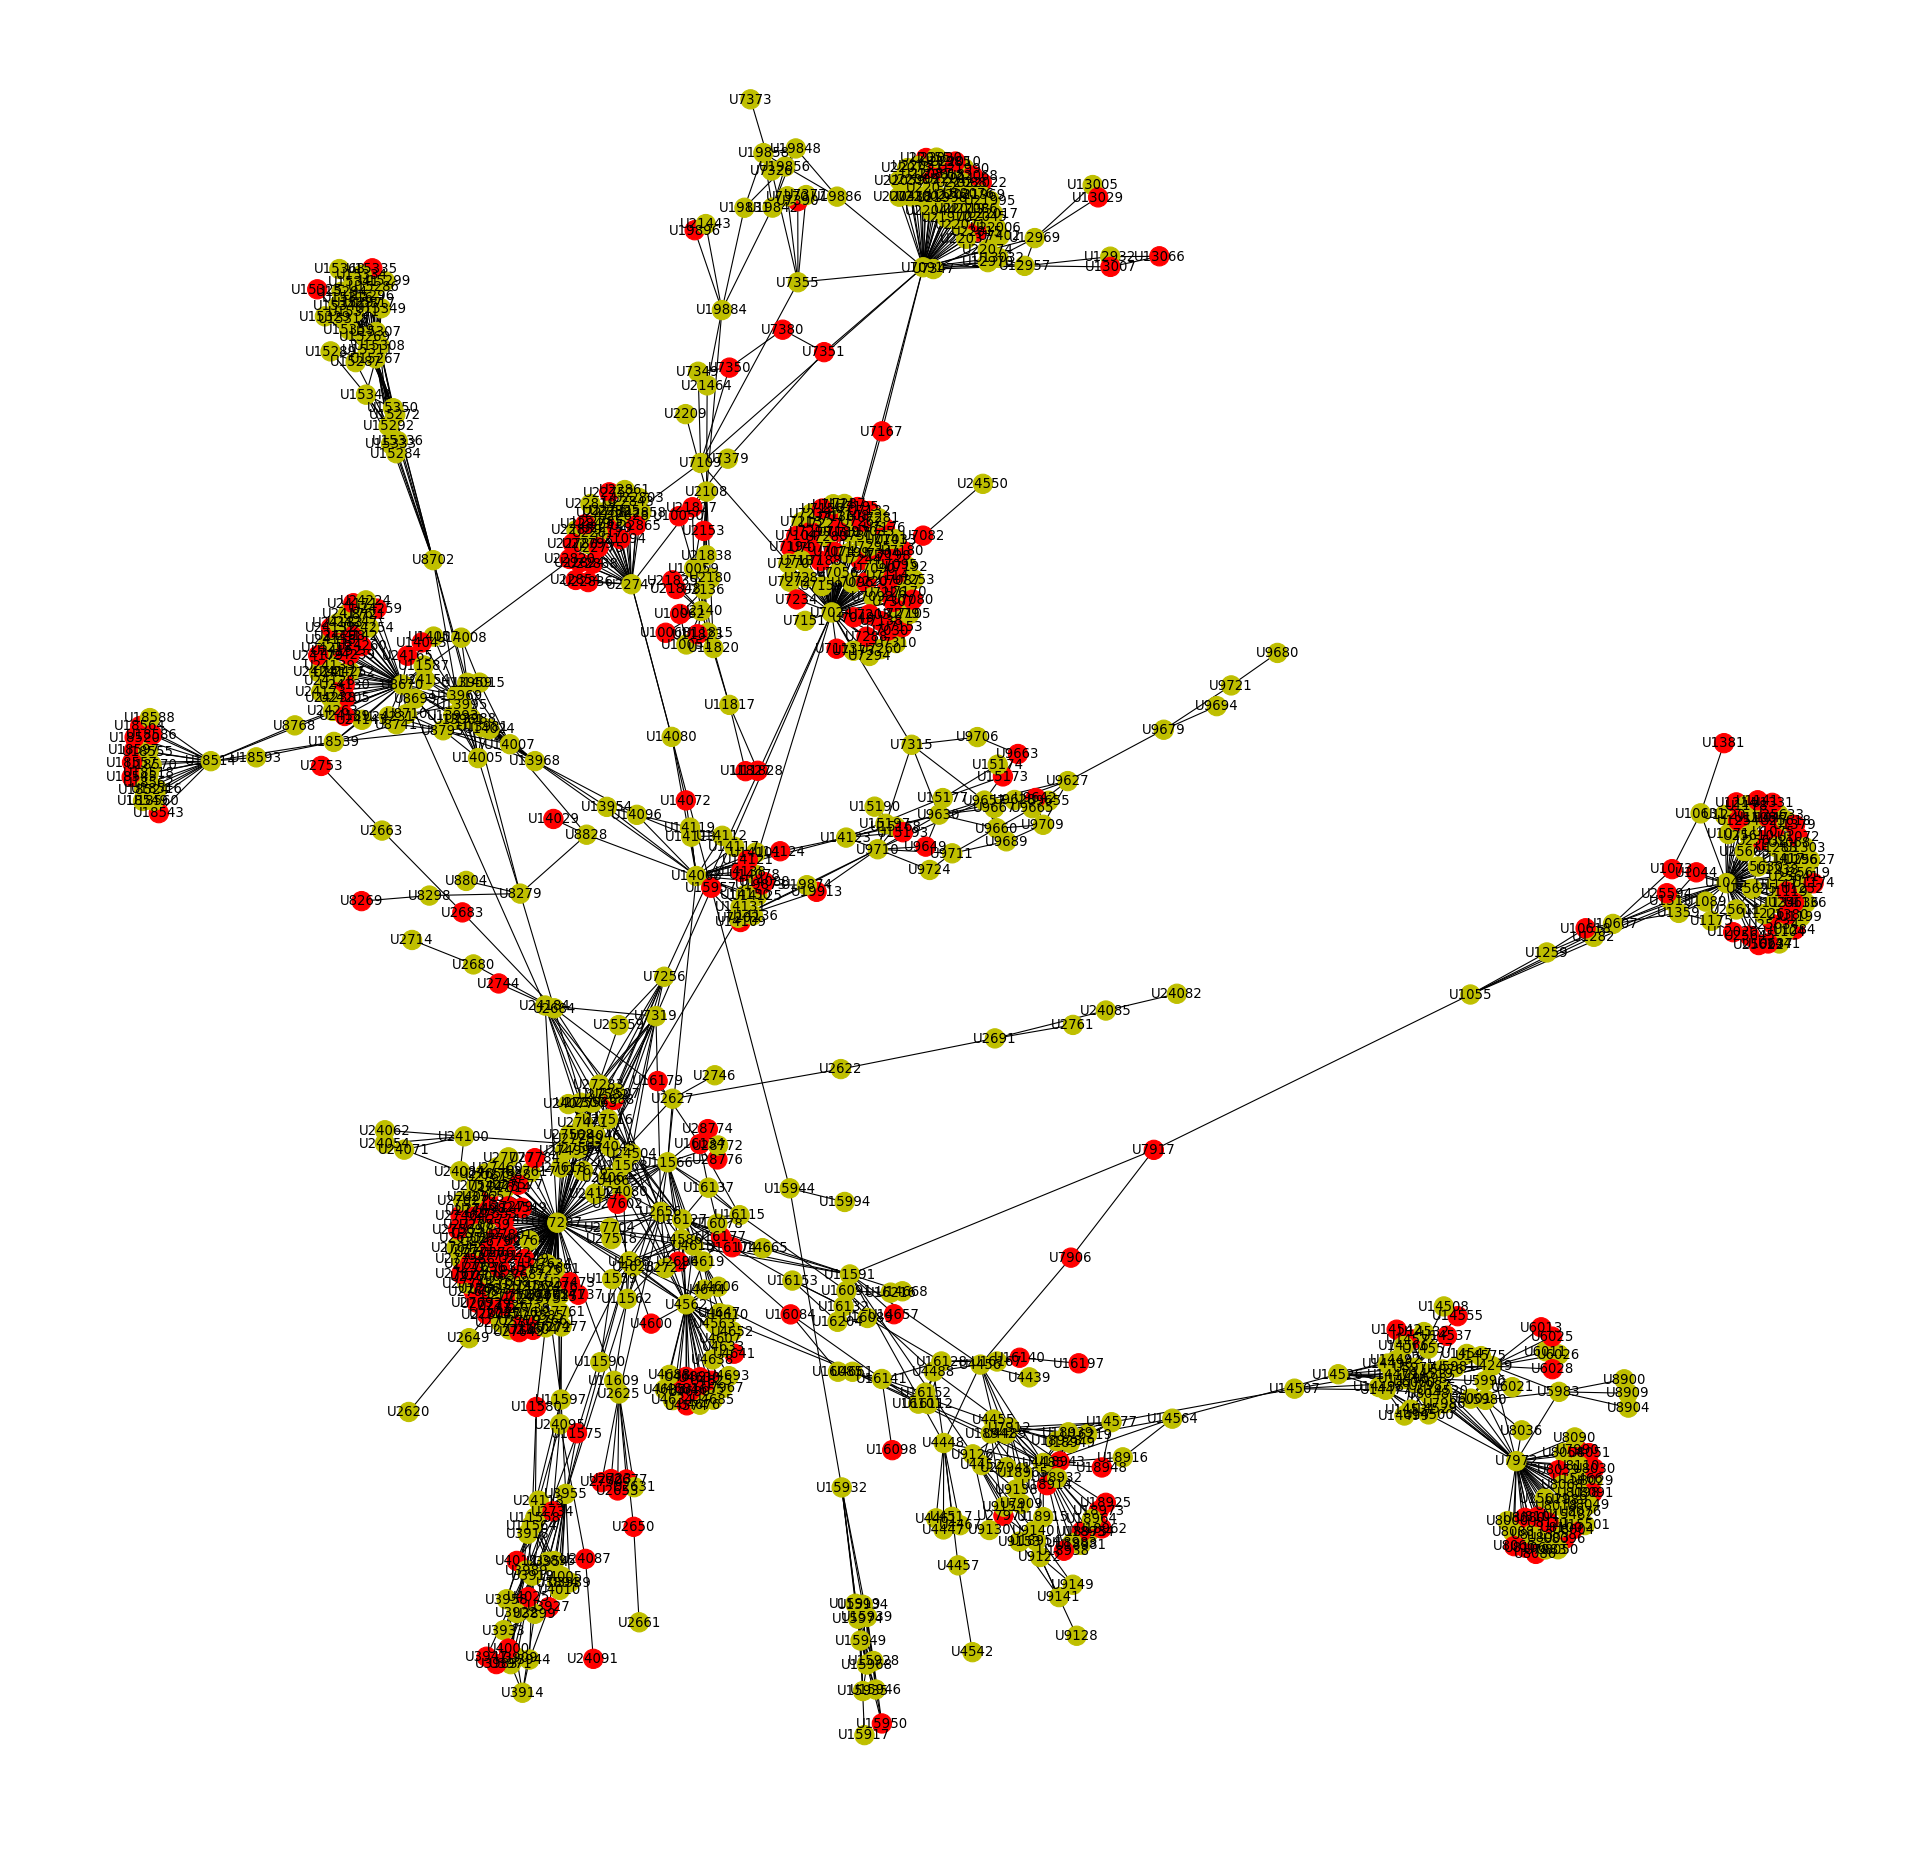

In [228]:
# 
for node in G:
    G.nodes()[node]['color'] = 'y'
for i in a:
    if a[i][0]!=groundtruth_location[i][0]:
        print('user '+i)
        print('pred '+a[i][0])
        print('real '+groundtruth_location[i][0])
        print('\n\n')
        G.nodes()[i]['color'] = 'r'
drawGraph(G)

In [277]:
def prediction_ego(G = G,empty_nodes = empty_nodes,attr = location):
    nbrs_values = []
    predicted_values={}
    for n in empty_nodes:
        predicted_values[n] = []
        flag_value=[]
        flag=''
        most_commun=''
        index=0
        hub_ego=nx.ego_graph(G,n,radius=6)
        for n0 in hub_ego:
            for nbr in hub_ego[n0]:
                hub_ego.add_edge(n0,nbr,weight = 10)
                if n0 in attr and nbr in attr:
                    for val in attr[nbr]:
                        flag = val
                        flag_value.append(flag)
                    if len(flag_value)>0:
                        hub_ego[n0][nbr]['weight']+=40
                        index+=1
                        
        partition=community.best_partition(hub_ego,weight='weight')
        curr_com=partition[n]
        nbr_com = [nodes for nodes in partition.keys() 
                   if partition[nodes] == curr_com]
        for nbr in nbr_com:
            if nbr in attr:
                for val in attr[nbr]:
                    nbrs_values.append(val)
        if nbrs_values:
            cpt = Counter(nbrs_values)
            most_commun,nb_occurrence = max(cpt.items(),key=lambda t:t[1])
        if index>0:
            for item in set(flag_value):
                predicted_values[n].append(item)
        else:
            predicted_values[n].append(most_commun)
#         print('user '+ n )
#         print(predicted_values[n])
    return predicted_values
pr = prediction_ego()


user U27476
['greater minneapolis-st. paul area', 'greater san diego area', 'sacramento california area', 'ithaca new york area', 'british columbia canada', 'greater atlanta area', 'greater detroit area', 'munich area germany', 'greater philadelphia area', 'tampa st. petersburg florida area', 'lincoln nebraska area', 'miami fort lauderdale area', 'shanghai city china', 'beijing city china', 'lawrence kansas area', 'washington d.c. metro area', 'wichita kansas area', 'norfolk virginia area', 'bengaluru area india', 'noida area india', 'bangladesh', 'charlotte north carolina area', 'athens georgia area', 'germany', 'greater new york city area', 'kuala lumpur malaysia', 'birmingham alabama area', 'greater nashville area', 'hungary', 'greater pittsburgh area', 'austin texas area', 'greater boston area', 'cincinnati area', 'phoenix arizona area', 'albany new york area', 'raleigh-durham north carolina area', 'greece', 'greater salt lake city area', 'columbia missouri area', 'mumbai area indi

user U27708
['greater minneapolis-st. paul area', 'greater san diego area', 'sacramento california area', 'ithaca new york area', 'british columbia canada', 'greater atlanta area', 'greater detroit area', 'munich area germany', 'greater philadelphia area', 'tampa st. petersburg florida area', 'lincoln nebraska area', 'miami fort lauderdale area', 'shanghai city china', 'beijing city china', 'lawrence kansas area', 'washington d.c. metro area', 'wichita kansas area', 'norfolk virginia area', 'bengaluru area india', 'noida area india', 'bangladesh', 'charlotte north carolina area', 'athens georgia area', 'germany', 'greater new york city area', 'kuala lumpur malaysia', 'birmingham alabama area', 'greater nashville area', 'hungary', 'greater pittsburgh area', 'austin texas area', 'greater boston area', 'cincinnati area', 'phoenix arizona area', 'albany new york area', 'raleigh-durham north carolina area', 'greece', 'greater salt lake city area', 'columbia missouri area', 'mumbai area indi

user U7912
['greater minneapolis-st. paul area', 'greater san diego area', 'ithaca new york area', 'british columbia canada', 'greater detroit area', 'munich area germany', 'greater philadelphia area', 'tampa st. petersburg florida area', 'lincoln nebraska area', 'shanghai city china', 'beijing city china', 'lawrence kansas area', 'washington d.c. metro area', 'wichita kansas area', 'norfolk virginia area', 'bangladesh', 'athens georgia area', 'germany', 'greater new york city area', 'kuala lumpur malaysia', 'birmingham alabama area', 'greater nashville area', 'hungary', 'austin texas area', 'greater boston area', 'phoenix arizona area', 'greater atlanta area', 'albany new york area', 'raleigh-durham north carolina area', 'greece', 'greater salt lake city area', 'columbia missouri area', 'lansing michigan area', 'urbana-champaign illinois area', 'portland oregon area', 'greater chicago area', 'baltimore maryland area', 'greenville south carolina area', 'charlotte north carolina area', 

user U7355
['greater san diego area', 'sacramento california area', 'ithaca new york area', 'british columbia canada', 'munich area germany', 'greater detroit area', 'greater philadelphia area', 'tampa st. petersburg florida area', 'miami fort lauderdale area', 'shanghai city china', 'washington d.c. metro area', 'wichita kansas area', 'bengaluru area india', 'noida area india', 'bangladesh', 'greater new york city area', 'kuala lumpur malaysia', 'birmingham alabama area', 'greater nashville area', 'hungary', 'greater pittsburgh area', 'austin texas area', 'cincinnati area', 'greater boston area', 'phoenix arizona area', 'greece', 'raleigh-durham north carolina area', 'greater atlanta area', 'greater los angeles area', 'charlotte north carolina area', 'mumbai area india', 'urbana-champaign illinois area', 'hyderabad area india', 'greater chicago area', 'eugene oregon area', 'greater seattle area', 'san francisco bay area', 'lille area france', 'finland', 'united states', 'bloomington n

user U24143
['greater minneapolis-st. paul area', 'greater san diego area', 'sacramento california area', 'ithaca new york area', 'british columbia canada', 'greater detroit area', 'munich area germany', 'greater philadelphia area', 'tampa st. petersburg florida area', 'miami fort lauderdale area', 'shanghai city china', 'washington d.c. metro area', 'wichita kansas area', 'bengaluru area india', 'noida area india', 'bangladesh', 'greater new york city area', 'kuala lumpur malaysia', 'birmingham alabama area', 'greater nashville area', 'hungary', 'greater pittsburgh area', 'austin texas area', 'greater boston area', 'cincinnati area', 'phoenix arizona area', 'albany new york area', 'raleigh-durham north carolina area', 'greece', 'greater salt lake city area', 'greater atlanta area', 'mumbai area india', 'urbana-champaign illinois area', 'hyderabad area india', 'greater chicago area', 'eugene oregon area', 'charlotte north carolina area', 'greater seattle area', 'san francisco bay area'

user U14005
['greater minneapolis-st. paul area', 'greater san diego area', 'sacramento california area', 'ithaca new york area', 'british columbia canada', 'greater detroit area', 'munich area germany', 'greater philadelphia area', 'tampa st. petersburg florida area', 'miami fort lauderdale area', 'shanghai city china', 'washington d.c. metro area', 'wichita kansas area', 'bengaluru area india', 'noida area india', 'bangladesh', 'greater new york city area', 'kuala lumpur malaysia', 'birmingham alabama area', 'greater nashville area', 'hungary', 'greater pittsburgh area', 'austin texas area', 'greater boston area', 'phoenix arizona area', 'greater atlanta area', 'albany new york area', 'raleigh-durham north carolina area', 'greece', 'greater salt lake city area', 'columbia missouri area', 'mumbai area india', 'urbana-champaign illinois area', 'hyderabad area india', 'greater chicago area', 'portland oregon area', 'eugene oregon area', 'charlotte north carolina area', 'greater seattle 

user U7087
['greater minneapolis-st. paul area', 'greater san diego area', 'sacramento california area', 'ithaca new york area', 'greater detroit area', 'munich area germany', 'greater philadelphia area', 'tampa st. petersburg florida area', 'miami fort lauderdale area', 'shanghai city china', 'washington d.c. metro area', 'bengaluru area india', 'noida area india', 'greater new york city area', 'kuala lumpur malaysia', 'greater nashville area', 'hungary', 'greater pittsburgh area', 'austin texas area', 'greater boston area', 'cincinnati area', 'phoenix arizona area', 'albany new york area', 'raleigh-durham north carolina area', 'greece', 'greater salt lake city area', 'greater atlanta area', 'mumbai area india', 'urbana-champaign illinois area', 'hyderabad area india', 'greater chicago area', 'eugene oregon area', 'charlotte north carolina area', 'greater seattle area', 'san francisco bay area', 'lille area france', 'greater los angeles area', 'finland', 'united states', 'bloomington 

user U2625
['greater minneapolis-st. paul area', 'greater san diego area', 'sacramento california area', 'ithaca new york area', 'british columbia canada', 'greater atlanta area', 'greater detroit area', 'munich area germany', 'greater philadelphia area', 'tampa st. petersburg florida area', 'lincoln nebraska area', 'miami fort lauderdale area', 'shanghai city china', 'beijing city china', 'lawrence kansas area', 'washington d.c. metro area', 'wichita kansas area', 'norfolk virginia area', 'bengaluru area india', 'noida area india', 'bangladesh', 'charlotte north carolina area', 'athens georgia area', 'germany', 'greater new york city area', 'kuala lumpur malaysia', 'birmingham alabama area', 'greater nashville area', 'hungary', 'greater pittsburgh area', 'austin texas area', 'greater boston area', 'cincinnati area', 'phoenix arizona area', 'albany new york area', 'raleigh-durham north carolina area', 'greece', 'greater salt lake city area', 'columbia missouri area', 'mumbai area india

user U8018
['beijing city china', 'bloomington normal illinois area', 'urbana-champaign illinois area', 'portland oregon area', 'greater chicago area', 'greater philadelphia area', 'columbia missouri area', 'china', 'madison wisconsin area']
user U27752
['greater minneapolis-st. paul area', 'greater san diego area', 'sacramento california area', 'ithaca new york area', 'british columbia canada', 'greater atlanta area', 'greater detroit area', 'munich area germany', 'greater philadelphia area', 'tampa st. petersburg florida area', 'lincoln nebraska area', 'miami fort lauderdale area', 'shanghai city china', 'beijing city china', 'lawrence kansas area', 'washington d.c. metro area', 'wichita kansas area', 'norfolk virginia area', 'bengaluru area india', 'noida area india', 'bangladesh', 'charlotte north carolina area', 'athens georgia area', 'germany', 'greater new york city area', 'kuala lumpur malaysia', 'birmingham alabama area', 'greater nashville area', 'hungary', 'greater pittsburg

user U15325
['greater san diego area', 'british columbia canada', 'ithaca new york area', 'munich area germany', 'greater philadelphia area', 'tampa st. petersburg florida area', 'miami fort lauderdale area', 'shanghai city china', 'washington d.c. metro area', 'wichita kansas area', 'bangladesh', 'greater new york city area', 'birmingham alabama area', 'kuala lumpur malaysia', 'hungary', 'austin texas area', 'greater boston area', 'phoenix arizona area', 'greater atlanta area', 'greece', 'raleigh-durham north carolina area', 'greater los angeles area', 'charlotte north carolina area', 'urbana-champaign illinois area', 'eugene oregon area', 'greater chicago area', 'greater seattle area', 'san francisco bay area', 'finland', 'united states', 'bloomington normal illinois area', 'copenhagen area denmark', 'beijing city china', 'singapore']
user U22825
['greater san diego area', 'sacramento california area', 'ithaca new york area', 'munich area germany', 'greater detroit area', 'greater ph

user U27463
['greater minneapolis-st. paul area', 'greater san diego area', 'sacramento california area', 'ithaca new york area', 'british columbia canada', 'greater atlanta area', 'greater detroit area', 'munich area germany', 'greater philadelphia area', 'tampa st. petersburg florida area', 'lincoln nebraska area', 'miami fort lauderdale area', 'shanghai city china', 'beijing city china', 'lawrence kansas area', 'washington d.c. metro area', 'wichita kansas area', 'norfolk virginia area', 'bengaluru area india', 'noida area india', 'bangladesh', 'charlotte north carolina area', 'athens georgia area', 'germany', 'greater new york city area', 'kuala lumpur malaysia', 'birmingham alabama area', 'greater nashville area', 'hungary', 'greater pittsburgh area', 'austin texas area', 'greater boston area', 'cincinnati area', 'phoenix arizona area', 'albany new york area', 'raleigh-durham north carolina area', 'greece', 'greater salt lake city area', 'columbia missouri area', 'mumbai area indi

user U4613
['greater minneapolis-st. paul area', 'greater san diego area', 'sacramento california area', 'ithaca new york area', 'british columbia canada', 'greater atlanta area', 'greater detroit area', 'munich area germany', 'greater philadelphia area', 'tampa st. petersburg florida area', 'lincoln nebraska area', 'miami fort lauderdale area', 'shanghai city china', 'beijing city china', 'lawrence kansas area', 'washington d.c. metro area', 'wichita kansas area', 'norfolk virginia area', 'bengaluru area india', 'noida area india', 'bangladesh', 'charlotte north carolina area', 'athens georgia area', 'germany', 'greater new york city area', 'kuala lumpur malaysia', 'birmingham alabama area', 'greater nashville area', 'hungary', 'greater pittsburgh area', 'austin texas area', 'greater boston area', 'cincinnati area', 'phoenix arizona area', 'albany new york area', 'raleigh-durham north carolina area', 'greece', 'greater salt lake city area', 'columbia missouri area', 'mumbai area india

user U4681
['greater minneapolis-st. paul area', 'greater san diego area', 'sacramento california area', 'ithaca new york area', 'british columbia canada', 'greater atlanta area', 'greater detroit area', 'munich area germany', 'greater philadelphia area', 'tampa st. petersburg florida area', 'miami fort lauderdale area', 'shanghai city china', 'beijing city china', 'washington d.c. metro area', 'wichita kansas area', 'bengaluru area india', 'noida area india', 'bangladesh', 'charlotte north carolina area', 'greater new york city area', 'kuala lumpur malaysia', 'birmingham alabama area', 'greater nashville area', 'hungary', 'greater pittsburgh area', 'austin texas area', 'greater boston area', 'cincinnati area', 'phoenix arizona area', 'albany new york area', 'raleigh-durham north carolina area', 'greece', 'greater salt lake city area', 'columbia missouri area', 'mumbai area india', 'urbana-champaign illinois area', 'hyderabad area india', 'greater chicago area', 'portland oregon area',

['greater minneapolis-st. paul area', 'greater san diego area', 'sacramento california area', 'ithaca new york area', 'greater detroit area', 'munich area germany', 'greater philadelphia area', 'tampa st. petersburg florida area', 'miami fort lauderdale area', 'shanghai city china', 'washington d.c. metro area', 'bengaluru area india', 'noida area india', 'greater new york city area', 'kuala lumpur malaysia', 'greater nashville area', 'hungary', 'greater pittsburgh area', 'austin texas area', 'greater boston area', 'cincinnati area', 'phoenix arizona area', 'albany new york area', 'raleigh-durham north carolina area', 'greece', 'greater salt lake city area', 'greater atlanta area', 'mumbai area india', 'urbana-champaign illinois area', 'hyderabad area india', 'greater chicago area', 'eugene oregon area', 'charlotte north carolina area', 'greater seattle area', 'san francisco bay area', 'lille area france', 'greater los angeles area', 'finland', 'united states', 'bloomington normal illi

user U4655
['greater minneapolis-st. paul area', 'greater san diego area', 'sacramento california area', 'ithaca new york area', 'british columbia canada', 'greater atlanta area', 'greater detroit area', 'munich area germany', 'greater philadelphia area', 'tampa st. petersburg florida area', 'miami fort lauderdale area', 'shanghai city china', 'beijing city china', 'washington d.c. metro area', 'wichita kansas area', 'bengaluru area india', 'noida area india', 'bangladesh', 'charlotte north carolina area', 'greater new york city area', 'kuala lumpur malaysia', 'birmingham alabama area', 'greater nashville area', 'hungary', 'greater pittsburgh area', 'austin texas area', 'greater boston area', 'cincinnati area', 'phoenix arizona area', 'albany new york area', 'raleigh-durham north carolina area', 'greece', 'greater salt lake city area', 'columbia missouri area', 'mumbai area india', 'urbana-champaign illinois area', 'hyderabad area india', 'greater chicago area', 'portland oregon area',

user U18518
['greater san diego area', 'sacramento california area', 'ithaca new york area', 'british columbia canada', 'munich area germany', 'greater detroit area', 'greater philadelphia area', 'tampa st. petersburg florida area', 'miami fort lauderdale area', 'shanghai city china', 'washington d.c. metro area', 'wichita kansas area', 'bangladesh', 'greater new york city area', 'kuala lumpur malaysia', 'birmingham alabama area', 'greater nashville area', 'hungary', 'austin texas area', 'greater boston area', 'phoenix arizona area', 'greater atlanta area', 'greece', 'raleigh-durham north carolina area', 'greater los angeles area', 'charlotte north carolina area', 'urbana-champaign illinois area', 'eugene oregon area', 'greater chicago area', 'greater seattle area', 'san francisco bay area', 'lille area france', 'finland', 'united states', 'bloomington normal illinois area', 'copenhagen area denmark', 'beijing city china', 'china', 'singapore']
user U27499
['greater minneapolis-st. pau

user U21094
['greater san diego area', 'sacramento california area', 'ithaca new york area', 'munich area germany', 'greater detroit area', 'greater philadelphia area', 'tampa st. petersburg florida area', 'shanghai city china', 'london united kingdom', 'washington d.c. metro area', 'bengaluru area india', 'noida area india', 'greater new york city area', 'kuala lumpur malaysia', 'greater nashville area', 'greater pittsburgh area', 'austin texas area', 'greater boston area', 'phoenix arizona area', 'greater atlanta area', 'ulm area germany', 'raleigh-durham north carolina area', 'greece', 'greater los angeles area', 'charlotte north carolina area', 'mumbai area india', 'urbana-champaign illinois area', 'hyderabad area india', 'greater chicago area', 'eugene oregon area', 'greater seattle area', 'san francisco bay area', 'finland', 'united states', 'chandigarh area india', 'bloomington normal illinois area', 'copenhagen area denmark', 'beijing city china', 'indianapolis indiana area']
u

user U3939
['greater minneapolis-st. paul area', 'greater san diego area', 'ithaca new york area', 'british columbia canada', 'greater detroit area', 'munich area germany', 'greater philadelphia area', 'tampa st. petersburg florida area', 'shanghai city china', 'washington d.c. metro area', 'wichita kansas area', 'bangladesh', 'greater new york city area', 'kuala lumpur malaysia', 'birmingham alabama area', 'greater nashville area', 'hungary', 'austin texas area', 'greater boston area', 'phoenix arizona area', 'greater atlanta area', 'albany new york area', 'raleigh-durham north carolina area', 'greece', 'greater salt lake city area', 'columbia missouri area', 'greater los angeles area', 'urbana-champaign illinois area', 'portland oregon area', 'greater chicago area', 'charlotte north carolina area', 'greater seattle area', 'san francisco bay area', 'lille area france', 'finland', 'united states', 'bloomington normal illinois area', 'copenhagen area denmark', 'beijing city china', 'chi

user U24130
['greater minneapolis-st. paul area', 'greater san diego area', 'sacramento california area', 'ithaca new york area', 'british columbia canada', 'greater detroit area', 'munich area germany', 'greater philadelphia area', 'tampa st. petersburg florida area', 'miami fort lauderdale area', 'shanghai city china', 'washington d.c. metro area', 'wichita kansas area', 'bengaluru area india', 'noida area india', 'bangladesh', 'greater new york city area', 'kuala lumpur malaysia', 'birmingham alabama area', 'greater nashville area', 'hungary', 'greater pittsburgh area', 'austin texas area', 'greater boston area', 'cincinnati area', 'phoenix arizona area', 'albany new york area', 'raleigh-durham north carolina area', 'greece', 'greater salt lake city area', 'greater atlanta area', 'mumbai area india', 'urbana-champaign illinois area', 'hyderabad area india', 'greater chicago area', 'eugene oregon area', 'charlotte north carolina area', 'greater seattle area', 'san francisco bay area'

user U24087
['greater minneapolis-st. paul area', 'greater san diego area', 'ithaca new york area', 'greater detroit area', 'munich area germany', 'greater philadelphia area', 'tampa st. petersburg florida area', 'miami fort lauderdale area', 'shanghai city china', 'beijing city china', 'washington d.c. metro area', 'charlotte north carolina area', 'greater new york city area', 'kuala lumpur malaysia', 'greater nashville area', 'austin texas area', 'greater boston area', 'cincinnati area', 'phoenix arizona area', 'albany new york area', 'raleigh-durham north carolina area', 'greece', 'greater salt lake city area', 'columbia missouri area', 'greater atlanta area', 'urbana-champaign illinois area', 'portland oregon area', 'greater chicago area', 'eugene oregon area', 'lansing michigan area', 'greenville south carolina area', 'san francisco bay area', 'lille area france', 'greater los angeles area', 'finland', 'united states', 'bloomington normal illinois area', 'copenhagen area denmark',

user U13007
['greater san diego area', 'sacramento california area', 'ithaca new york area', 'munich area germany', 'greater philadelphia area', 'tampa st. petersburg florida area', 'miami fort lauderdale area', 'shanghai city china', 'bengaluru area india', 'noida area india', 'greater new york city area', 'kuala lumpur malaysia', 'greater pittsburgh area', 'austin texas area', 'cincinnati area', 'greater atlanta area', 'greater los angeles area', 'raleigh-durham north carolina area', 'charlotte north carolina area', 'mumbai area india', 'urbana-champaign illinois area', 'hyderabad area india', 'greater chicago area', 'eugene oregon area', 'greater seattle area', 'san francisco bay area', 'finland', 'united states', 'bloomington normal illinois area', 'beijing city china']
user U2684
['greater minneapolis-st. paul area', 'greater san diego area', 'sacramento california area', 'ithaca new york area', 'greater atlanta area', 'greater detroit area', 'munich area germany', 'greater philad

user U14138
['greater minneapolis-st. paul area', 'greater san diego area', 'sacramento california area', 'ithaca new york area', 'british columbia canada', 'greater atlanta area', 'greater detroit area', 'munich area germany', 'greater philadelphia area', 'tampa st. petersburg florida area', 'miami fort lauderdale area', 'shanghai city china', 'beijing city china', 'washington d.c. metro area', 'wichita kansas area', 'bengaluru area india', 'noida area india', 'bangladesh', 'greater new york city area', 'kuala lumpur malaysia', 'birmingham alabama area', 'greater nashville area', 'hungary', 'greater pittsburgh area', 'austin texas area', 'greater boston area', 'cincinnati area', 'phoenix arizona area', 'albany new york area', 'raleigh-durham north carolina area', 'greece', 'greater salt lake city area', 'columbia missouri area', 'mumbai area india', 'urbana-champaign illinois area', 'hyderabad area india', 'greater chicago area', 'portland oregon area', 'eugene oregon area', 'charlott

user U4461
['greater minneapolis-st. paul area', 'greater san diego area', 'ithaca new york area', 'greater detroit area', 'munich area germany', 'greater philadelphia area', 'tampa st. petersburg florida area', 'lincoln nebraska area', 'shanghai city china', 'beijing city china', 'lawrence kansas area', 'washington d.c. metro area', 'norfolk virginia area', 'athens georgia area', 'germany', 'greater new york city area', 'kuala lumpur malaysia', 'greater nashville area', 'austin texas area', 'greater boston area', 'phoenix arizona area', 'greater atlanta area', 'albany new york area', 'greece', 'greater salt lake city area', 'greater los angeles area', 'columbia missouri area', 'lansing michigan area', 'urbana-champaign illinois area', 'portland oregon area', 'greater chicago area', 'baltimore maryland area', 'greenville south carolina area', 'charlotte north carolina area', 'ncr - national capital region philippines', 'tulsa oklahoma area', 'san francisco bay area', 'lille area france

user U27634
['greater minneapolis-st. paul area', 'greater san diego area', 'sacramento california area', 'ithaca new york area', 'british columbia canada', 'greater atlanta area', 'greater detroit area', 'munich area germany', 'greater philadelphia area', 'tampa st. petersburg florida area', 'lincoln nebraska area', 'miami fort lauderdale area', 'shanghai city china', 'beijing city china', 'lawrence kansas area', 'washington d.c. metro area', 'wichita kansas area', 'norfolk virginia area', 'bengaluru area india', 'noida area india', 'bangladesh', 'charlotte north carolina area', 'athens georgia area', 'germany', 'greater new york city area', 'kuala lumpur malaysia', 'birmingham alabama area', 'greater nashville area', 'hungary', 'greater pittsburgh area', 'austin texas area', 'greater boston area', 'cincinnati area', 'phoenix arizona area', 'albany new york area', 'raleigh-durham north carolina area', 'greece', 'greater salt lake city area', 'columbia missouri area', 'mumbai area indi

user U15335
['greater san diego area', 'british columbia canada', 'ithaca new york area', 'munich area germany', 'greater philadelphia area', 'tampa st. petersburg florida area', 'miami fort lauderdale area', 'shanghai city china', 'washington d.c. metro area', 'wichita kansas area', 'bangladesh', 'greater new york city area', 'birmingham alabama area', 'kuala lumpur malaysia', 'hungary', 'austin texas area', 'greater boston area', 'phoenix arizona area', 'greater atlanta area', 'greece', 'raleigh-durham north carolina area', 'greater los angeles area', 'charlotte north carolina area', 'urbana-champaign illinois area', 'eugene oregon area', 'greater chicago area', 'greater seattle area', 'san francisco bay area', 'finland', 'united states', 'bloomington normal illinois area', 'copenhagen area denmark', 'beijing city china', 'singapore']
user U15296
['greater san diego area', 'british columbia canada', 'ithaca new york area', 'munich area germany', 'greater philadelphia area', 'tampa st

user U4685
['greater minneapolis-st. paul area', 'greater san diego area', 'sacramento california area', 'ithaca new york area', 'british columbia canada', 'greater atlanta area', 'greater detroit area', 'munich area germany', 'greater philadelphia area', 'tampa st. petersburg florida area', 'miami fort lauderdale area', 'shanghai city china', 'beijing city china', 'washington d.c. metro area', 'wichita kansas area', 'bengaluru area india', 'noida area india', 'bangladesh', 'charlotte north carolina area', 'greater new york city area', 'kuala lumpur malaysia', 'birmingham alabama area', 'greater nashville area', 'hungary', 'greater pittsburgh area', 'austin texas area', 'greater boston area', 'cincinnati area', 'phoenix arizona area', 'albany new york area', 'raleigh-durham north carolina area', 'greece', 'greater salt lake city area', 'columbia missouri area', 'mumbai area india', 'urbana-champaign illinois area', 'hyderabad area india', 'greater chicago area', 'portland oregon area',

user U18560
['greater san diego area', 'sacramento california area', 'ithaca new york area', 'british columbia canada', 'munich area germany', 'greater detroit area', 'greater philadelphia area', 'tampa st. petersburg florida area', 'miami fort lauderdale area', 'shanghai city china', 'washington d.c. metro area', 'wichita kansas area', 'bangladesh', 'greater new york city area', 'kuala lumpur malaysia', 'birmingham alabama area', 'greater nashville area', 'hungary', 'austin texas area', 'greater boston area', 'phoenix arizona area', 'greater atlanta area', 'greece', 'raleigh-durham north carolina area', 'greater los angeles area', 'charlotte north carolina area', 'urbana-champaign illinois area', 'eugene oregon area', 'greater chicago area', 'greater seattle area', 'san francisco bay area', 'lille area france', 'finland', 'united states', 'bloomington normal illinois area', 'copenhagen area denmark', 'beijing city china', 'china', 'singapore']
user U4455
['greater minneapolis-st. paul

user U10068
['urbana-champaign illinois area', 'greater chicago area', 'raleigh-durham north carolina area']
user U15267
['greater san diego area', 'ithaca new york area', 'british columbia canada', 'munich area germany', 'greater detroit area', 'greater philadelphia area', 'tampa st. petersburg florida area', 'miami fort lauderdale area', 'shanghai city china', 'washington d.c. metro area', 'wichita kansas area', 'bangladesh', 'greater new york city area', 'kuala lumpur malaysia', 'birmingham alabama area', 'greater nashville area', 'hungary', 'austin texas area', 'greater boston area', 'phoenix arizona area', 'greater atlanta area', 'greece', 'raleigh-durham north carolina area', 'greater los angeles area', 'charlotte north carolina area', 'columbia missouri area', 'urbana-champaign illinois area', 'portland oregon area', 'greater chicago area', 'eugene oregon area', 'greater seattle area', 'san francisco bay area', 'lille area france', 'finland', 'united states', 'bloomington normal

user U27698
['greater minneapolis-st. paul area', 'greater san diego area', 'sacramento california area', 'ithaca new york area', 'british columbia canada', 'greater atlanta area', 'greater detroit area', 'munich area germany', 'greater philadelphia area', 'tampa st. petersburg florida area', 'lincoln nebraska area', 'miami fort lauderdale area', 'shanghai city china', 'beijing city china', 'lawrence kansas area', 'washington d.c. metro area', 'wichita kansas area', 'norfolk virginia area', 'bengaluru area india', 'noida area india', 'bangladesh', 'charlotte north carolina area', 'athens georgia area', 'germany', 'greater new york city area', 'kuala lumpur malaysia', 'birmingham alabama area', 'greater nashville area', 'hungary', 'greater pittsburgh area', 'austin texas area', 'greater boston area', 'cincinnati area', 'phoenix arizona area', 'albany new york area', 'raleigh-durham north carolina area', 'greece', 'greater salt lake city area', 'columbia missouri area', 'mumbai area indi

user U4641
['greater minneapolis-st. paul area', 'greater san diego area', 'sacramento california area', 'ithaca new york area', 'british columbia canada', 'greater atlanta area', 'greater detroit area', 'munich area germany', 'greater philadelphia area', 'tampa st. petersburg florida area', 'miami fort lauderdale area', 'shanghai city china', 'beijing city china', 'washington d.c. metro area', 'wichita kansas area', 'bengaluru area india', 'noida area india', 'bangladesh', 'charlotte north carolina area', 'greater new york city area', 'kuala lumpur malaysia', 'birmingham alabama area', 'greater nashville area', 'hungary', 'greater pittsburgh area', 'austin texas area', 'greater boston area', 'cincinnati area', 'phoenix arizona area', 'albany new york area', 'raleigh-durham north carolina area', 'greece', 'greater salt lake city area', 'columbia missouri area', 'mumbai area india', 'urbana-champaign illinois area', 'hyderabad area india', 'greater chicago area', 'portland oregon area',

user U27600
['greater minneapolis-st. paul area', 'greater san diego area', 'sacramento california area', 'ithaca new york area', 'british columbia canada', 'greater atlanta area', 'greater detroit area', 'munich area germany', 'greater philadelphia area', 'tampa st. petersburg florida area', 'lincoln nebraska area', 'miami fort lauderdale area', 'shanghai city china', 'beijing city china', 'lawrence kansas area', 'washington d.c. metro area', 'wichita kansas area', 'norfolk virginia area', 'bengaluru area india', 'noida area india', 'bangladesh', 'charlotte north carolina area', 'athens georgia area', 'germany', 'greater new york city area', 'kuala lumpur malaysia', 'birmingham alabama area', 'greater nashville area', 'hungary', 'greater pittsburgh area', 'austin texas area', 'greater boston area', 'cincinnati area', 'phoenix arizona area', 'albany new york area', 'raleigh-durham north carolina area', 'greece', 'greater salt lake city area', 'columbia missouri area', 'mumbai area indi

user U27515
['greater minneapolis-st. paul area', 'greater san diego area', 'sacramento california area', 'ithaca new york area', 'british columbia canada', 'greater atlanta area', 'greater detroit area', 'munich area germany', 'greater philadelphia area', 'tampa st. petersburg florida area', 'lincoln nebraska area', 'miami fort lauderdale area', 'shanghai city china', 'beijing city china', 'lawrence kansas area', 'washington d.c. metro area', 'wichita kansas area', 'norfolk virginia area', 'bengaluru area india', 'noida area india', 'bangladesh', 'charlotte north carolina area', 'athens georgia area', 'germany', 'greater new york city area', 'kuala lumpur malaysia', 'birmingham alabama area', 'greater nashville area', 'hungary', 'greater pittsburgh area', 'austin texas area', 'greater boston area', 'cincinnati area', 'phoenix arizona area', 'albany new york area', 'raleigh-durham north carolina area', 'greece', 'greater salt lake city area', 'columbia missouri area', 'mumbai area indi

user U27663
['greater minneapolis-st. paul area', 'greater san diego area', 'sacramento california area', 'ithaca new york area', 'british columbia canada', 'greater atlanta area', 'greater detroit area', 'munich area germany', 'greater philadelphia area', 'tampa st. petersburg florida area', 'lincoln nebraska area', 'miami fort lauderdale area', 'shanghai city china', 'beijing city china', 'lawrence kansas area', 'washington d.c. metro area', 'wichita kansas area', 'norfolk virginia area', 'bengaluru area india', 'noida area india', 'bangladesh', 'charlotte north carolina area', 'athens georgia area', 'germany', 'greater new york city area', 'kuala lumpur malaysia', 'birmingham alabama area', 'greater nashville area', 'hungary', 'greater pittsburgh area', 'austin texas area', 'greater boston area', 'cincinnati area', 'phoenix arizona area', 'albany new york area', 'raleigh-durham north carolina area', 'greece', 'greater salt lake city area', 'columbia missouri area', 'mumbai area indi

user U14121
['greater minneapolis-st. paul area', 'greater san diego area', 'sacramento california area', 'ithaca new york area', 'british columbia canada', 'greater atlanta area', 'greater detroit area', 'munich area germany', 'greater philadelphia area', 'tampa st. petersburg florida area', 'miami fort lauderdale area', 'shanghai city china', 'beijing city china', 'washington d.c. metro area', 'wichita kansas area', 'bengaluru area india', 'noida area india', 'bangladesh', 'greater new york city area', 'kuala lumpur malaysia', 'birmingham alabama area', 'greater nashville area', 'hungary', 'greater pittsburgh area', 'austin texas area', 'greater boston area', 'cincinnati area', 'phoenix arizona area', 'albany new york area', 'raleigh-durham north carolina area', 'greece', 'greater salt lake city area', 'columbia missouri area', 'mumbai area india', 'urbana-champaign illinois area', 'hyderabad area india', 'greater chicago area', 'portland oregon area', 'eugene oregon area', 'charlott

user U7080
['greater minneapolis-st. paul area', 'greater san diego area', 'sacramento california area', 'ithaca new york area', 'greater detroit area', 'munich area germany', 'greater philadelphia area', 'tampa st. petersburg florida area', 'miami fort lauderdale area', 'shanghai city china', 'washington d.c. metro area', 'bengaluru area india', 'noida area india', 'greater new york city area', 'kuala lumpur malaysia', 'greater nashville area', 'hungary', 'greater pittsburgh area', 'austin texas area', 'greater boston area', 'cincinnati area', 'phoenix arizona area', 'albany new york area', 'raleigh-durham north carolina area', 'greece', 'greater salt lake city area', 'greater atlanta area', 'mumbai area india', 'urbana-champaign illinois area', 'hyderabad area india', 'greater chicago area', 'eugene oregon area', 'charlotte north carolina area', 'greater seattle area', 'san francisco bay area', 'lille area france', 'greater los angeles area', 'finland', 'united states', 'bloomington 

user U7326
['greater san diego area', 'sacramento california area', 'ithaca new york area', 'munich area germany', 'greater philadelphia area', 'tampa st. petersburg florida area', 'miami fort lauderdale area', 'shanghai city china', 'washington d.c. metro area', 'greater new york city area', 'kuala lumpur malaysia', 'hungary', 'austin texas area', 'cincinnati area', 'phoenix arizona area', 'greater atlanta area', 'greece', 'raleigh-durham north carolina area', 'greater los angeles area', 'charlotte north carolina area', 'urbana-champaign illinois area', 'eugene oregon area', 'greater chicago area', 'greater seattle area', 'san francisco bay area', 'finland', 'united states', 'bloomington normal illinois area', 'copenhagen area denmark', 'beijing city china']
user U8068
['beijing city china', 'bloomington normal illinois area', 'urbana-champaign illinois area', 'portland oregon area', 'greater chicago area', 'greater philadelphia area', 'columbia missouri area', 'china', 'madison wisco

user U10050
['urbana-champaign illinois area', 'greater chicago area', 'raleigh-durham north carolina area']
user U1226
['greater minneapolis-st. paul area', 'greater san diego area', 'ithaca new york area', 'greater philadelphia area', 'lincoln nebraska area', 'tampa st. petersburg florida area', 'shanghai city china', 'lawrence kansas area', 'washington d.c. metro area', 'norfolk virginia area', 'athens georgia area', 'germany', 'greater new york city area', 'austin texas area', 'greater boston area', 'phoenix arizona area', 'albany new york area', 'greater los angeles area', 'lansing michigan area', 'urbana-champaign illinois area', 'baltimore maryland area', 'greater chicago area', 'ncr - national capital region philippines', 'tulsa oklahoma area', 'san francisco bay area', 'lille area france', 'finland', 'united states', 'iowa city iowa area', 'portland maine area', 'beijing city china', 'china', 'madison wisconsin area']
user U15957
['greater san diego area', 'sacramento californ

user U1047
['greater minneapolis-st. paul area', 'greater san diego area', 'ithaca new york area', 'greater philadelphia area', 'lincoln nebraska area', 'tampa st. petersburg florida area', 'shanghai city china', 'lawrence kansas area', 'washington d.c. metro area', 'norfolk virginia area', 'athens georgia area', 'germany', 'greater new york city area', 'austin texas area', 'greater boston area', 'phoenix arizona area', 'albany new york area', 'greater los angeles area', 'lansing michigan area', 'urbana-champaign illinois area', 'baltimore maryland area', 'greater chicago area', 'ncr - national capital region philippines', 'tulsa oklahoma area', 'san francisco bay area', 'lille area france', 'finland', 'united states', 'iowa city iowa area', 'portland maine area', 'beijing city china', 'china', 'madison wisconsin area']
user U6028
['beijing city china', 'bloomington normal illinois area', 'urbana-champaign illinois area', 'portland oregon area', 'greater chicago area', 'greater philade

user U25636
['greater minneapolis-st. paul area', 'greater san diego area', 'ithaca new york area', 'greater philadelphia area', 'lincoln nebraska area', 'tampa st. petersburg florida area', 'shanghai city china', 'lawrence kansas area', 'washington d.c. metro area', 'norfolk virginia area', 'athens georgia area', 'germany', 'greater new york city area', 'austin texas area', 'greater boston area', 'phoenix arizona area', 'albany new york area', 'greater los angeles area', 'lansing michigan area', 'urbana-champaign illinois area', 'baltimore maryland area', 'greater chicago area', 'ncr - national capital region philippines', 'tulsa oklahoma area', 'san francisco bay area', 'lille area france', 'finland', 'united states', 'iowa city iowa area', 'portland maine area', 'beijing city china', 'china', 'madison wisconsin area']
user U1254
['greater minneapolis-st. paul area', 'greater san diego area', 'ithaca new york area', 'greater philadelphia area', 'lincoln nebraska area', 'tampa st. pet

user U27508
['greater minneapolis-st. paul area', 'greater san diego area', 'sacramento california area', 'ithaca new york area', 'british columbia canada', 'greater atlanta area', 'greater detroit area', 'munich area germany', 'greater philadelphia area', 'tampa st. petersburg florida area', 'lincoln nebraska area', 'miami fort lauderdale area', 'shanghai city china', 'beijing city china', 'lawrence kansas area', 'washington d.c. metro area', 'wichita kansas area', 'norfolk virginia area', 'bengaluru area india', 'noida area india', 'bangladesh', 'charlotte north carolina area', 'athens georgia area', 'germany', 'greater new york city area', 'kuala lumpur malaysia', 'birmingham alabama area', 'greater nashville area', 'hungary', 'greater pittsburgh area', 'austin texas area', 'greater boston area', 'cincinnati area', 'phoenix arizona area', 'albany new york area', 'raleigh-durham north carolina area', 'greece', 'greater salt lake city area', 'columbia missouri area', 'mumbai area indi

user U27737
['greater minneapolis-st. paul area', 'greater san diego area', 'sacramento california area', 'ithaca new york area', 'british columbia canada', 'greater atlanta area', 'greater detroit area', 'munich area germany', 'greater philadelphia area', 'tampa st. petersburg florida area', 'lincoln nebraska area', 'miami fort lauderdale area', 'shanghai city china', 'beijing city china', 'lawrence kansas area', 'washington d.c. metro area', 'wichita kansas area', 'norfolk virginia area', 'bengaluru area india', 'noida area india', 'bangladesh', 'charlotte north carolina area', 'athens georgia area', 'germany', 'greater new york city area', 'kuala lumpur malaysia', 'birmingham alabama area', 'greater nashville area', 'hungary', 'greater pittsburgh area', 'austin texas area', 'greater boston area', 'cincinnati area', 'phoenix arizona area', 'albany new york area', 'raleigh-durham north carolina area', 'greece', 'greater salt lake city area', 'columbia missouri area', 'mumbai area indi

user U27602
['greater minneapolis-st. paul area', 'greater san diego area', 'sacramento california area', 'ithaca new york area', 'british columbia canada', 'greater atlanta area', 'greater detroit area', 'munich area germany', 'greater philadelphia area', 'tampa st. petersburg florida area', 'lincoln nebraska area', 'miami fort lauderdale area', 'shanghai city china', 'beijing city china', 'lawrence kansas area', 'washington d.c. metro area', 'wichita kansas area', 'norfolk virginia area', 'bengaluru area india', 'noida area india', 'bangladesh', 'charlotte north carolina area', 'athens georgia area', 'germany', 'greater new york city area', 'kuala lumpur malaysia', 'birmingham alabama area', 'greater nashville area', 'hungary', 'greater pittsburgh area', 'austin texas area', 'greater boston area', 'cincinnati area', 'phoenix arizona area', 'albany new york area', 'raleigh-durham north carolina area', 'greece', 'greater salt lake city area', 'columbia missouri area', 'mumbai area indi

user U19848
['greater san diego area', 'sacramento california area', 'ithaca new york area', 'munich area germany', 'greater philadelphia area', 'tampa st. petersburg florida area', 'miami fort lauderdale area', 'shanghai city china', 'bengaluru area india', 'noida area india', 'greater new york city area', 'kuala lumpur malaysia', 'greater pittsburgh area', 'austin texas area', 'cincinnati area', 'greater atlanta area', 'greater los angeles area', 'raleigh-durham north carolina area', 'charlotte north carolina area', 'mumbai area india', 'urbana-champaign illinois area', 'hyderabad area india', 'greater chicago area', 'eugene oregon area', 'greater seattle area', 'san francisco bay area', 'finland', 'united states', 'bloomington normal illinois area', 'beijing city china']
user U14537
['beijing city china', 'greater minneapolis-st. paul area', 'greater los angeles area', 'bloomington normal illinois area', 'urbana-champaign illinois area', 'portland oregon area', 'greater chicago area

user U19873
['greater minneapolis-st. paul area', 'greater san diego area', 'sacramento california area', 'ithaca new york area', 'greater detroit area', 'munich area germany', 'greater philadelphia area', 'tampa st. petersburg florida area', 'shanghai city china', 'beijing city china', 'washington d.c. metro area', 'greater new york city area', 'kuala lumpur malaysia', 'greater nashville area', 'austin texas area', 'greater boston area', 'cincinnati area', 'phoenix arizona area', 'albany new york area', 'raleigh-durham north carolina area', 'greece', 'greater salt lake city area', 'greater atlanta area', 'greater los angeles area', 'urbana-champaign illinois area', 'eugene oregon area', 'greater chicago area', 'charlotte north carolina area', 'san francisco bay area', 'lille area france', 'finland', 'united states', 'bloomington normal illinois area', 'copenhagen area denmark', 'greater seattle area', 'china']
user U2744
['greater minneapolis-st. paul area', 'greater san diego area', 

user U18593
['greater san diego area', 'sacramento california area', 'ithaca new york area', 'british columbia canada', 'munich area germany', 'greater detroit area', 'greater philadelphia area', 'tampa st. petersburg florida area', 'miami fort lauderdale area', 'shanghai city china', 'washington d.c. metro area', 'wichita kansas area', 'bangladesh', 'greater new york city area', 'kuala lumpur malaysia', 'birmingham alabama area', 'greater nashville area', 'hungary', 'austin texas area', 'greater boston area', 'phoenix arizona area', 'greater atlanta area', 'greece', 'raleigh-durham north carolina area', 'greater los angeles area', 'charlotte north carolina area', 'urbana-champaign illinois area', 'eugene oregon area', 'greater chicago area', 'greater seattle area', 'san francisco bay area', 'lille area france', 'finland', 'united states', 'bloomington normal illinois area', 'copenhagen area denmark', 'beijing city china', 'china', 'singapore']
user U18949
['greater minneapolis-st. pau

user U18586
['greater san diego area', 'sacramento california area', 'ithaca new york area', 'british columbia canada', 'munich area germany', 'greater detroit area', 'greater philadelphia area', 'tampa st. petersburg florida area', 'miami fort lauderdale area', 'shanghai city china', 'washington d.c. metro area', 'wichita kansas area', 'bangladesh', 'greater new york city area', 'kuala lumpur malaysia', 'birmingham alabama area', 'greater nashville area', 'hungary', 'austin texas area', 'greater boston area', 'phoenix arizona area', 'greater atlanta area', 'greece', 'raleigh-durham north carolina area', 'greater los angeles area', 'charlotte north carolina area', 'urbana-champaign illinois area', 'eugene oregon area', 'greater chicago area', 'greater seattle area', 'san francisco bay area', 'lille area france', 'finland', 'united states', 'bloomington normal illinois area', 'copenhagen area denmark', 'beijing city china', 'china', 'singapore']
user U16219
['greater minneapolis-st. pau

user U1119
['greater minneapolis-st. paul area', 'greater san diego area', 'ithaca new york area', 'greater philadelphia area', 'lincoln nebraska area', 'tampa st. petersburg florida area', 'shanghai city china', 'lawrence kansas area', 'washington d.c. metro area', 'norfolk virginia area', 'athens georgia area', 'germany', 'greater new york city area', 'austin texas area', 'greater boston area', 'phoenix arizona area', 'albany new york area', 'greater los angeles area', 'lansing michigan area', 'urbana-champaign illinois area', 'baltimore maryland area', 'greater chicago area', 'ncr - national capital region philippines', 'tulsa oklahoma area', 'san francisco bay area', 'lille area france', 'finland', 'united states', 'iowa city iowa area', 'portland maine area', 'beijing city china', 'china', 'madison wisconsin area']
user U12970
['greater san diego area', 'sacramento california area', 'ithaca new york area', 'munich area germany', 'greater detroit area', 'greater philadelphia area',

user U27784
['greater minneapolis-st. paul area', 'greater san diego area', 'sacramento california area', 'ithaca new york area', 'british columbia canada', 'greater atlanta area', 'greater detroit area', 'munich area germany', 'greater philadelphia area', 'tampa st. petersburg florida area', 'lincoln nebraska area', 'miami fort lauderdale area', 'shanghai city china', 'beijing city china', 'lawrence kansas area', 'washington d.c. metro area', 'wichita kansas area', 'norfolk virginia area', 'bengaluru area india', 'noida area india', 'bangladesh', 'charlotte north carolina area', 'athens georgia area', 'germany', 'greater new york city area', 'kuala lumpur malaysia', 'birmingham alabama area', 'greater nashville area', 'hungary', 'greater pittsburgh area', 'austin texas area', 'greater boston area', 'cincinnati area', 'phoenix arizona area', 'albany new york area', 'raleigh-durham north carolina area', 'greece', 'greater salt lake city area', 'columbia missouri area', 'mumbai area indi

In [393]:
testLocation(pr)
testCollege()

print the groudtruth rate for location_prediction
76.210526% of the predictions are true


TypeError: testCollege() missing 1 required positional argument: 'college_prediction'

In [260]:
pr

{'U10050': ['urbana-champaign illinois area',
  'greater chicago area',
  'raleigh-durham north carolina area'],
 'U10059': ['urbana-champaign illinois area',
  'greater chicago area',
  'raleigh-durham north carolina area'],
 'U10062': ['urbana-champaign illinois area',
  'greater chicago area',
  'raleigh-durham north carolina area'],
 'U10068': ['urbana-champaign illinois area',
  'greater chicago area',
  'raleigh-durham north carolina area'],
 'U1044': ['greater minneapolis-st. paul area',
  'greater san diego area',
  'ithaca new york area',
  'greater philadelphia area',
  'lincoln nebraska area',
  'tampa st. petersburg florida area',
  'shanghai city china',
  'lawrence kansas area',
  'washington d.c. metro area',
  'norfolk virginia area',
  'athens georgia area',
  'germany',
  'greater new york city area',
  'austin texas area',
  'greater boston area',
  'phoenix arizona area',
  'albany new york area',
  'greater los angeles area',
  'lansing michigan area',
  'urbana-ch